In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import matplotlib.ticker as mtick
import numpy as np
import matplotlib.patches as mpatches
from collections import defaultdict

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


sns.set(style="whitegrid",font_scale=2.5)

In [4]:
### read data
qwen = pd.read_csv("../data/qwen_v8.csv")
qwen = qwen[~qwen.json_response.isna()]
ernie = pd.read_csv("../data/ernie_v8.csv")
ernie = ernie[~ernie.json_response.isna()]
baidu = pd.read_csv("../data/baidu_v7.csv")

In [5]:
order = [
 'age',
    'physical_appearance',
 'disability',
 'disease',
 'educational_qualification',
 'ethnicity',
 'gender',
 'nationality',
 'race',
 'region',
 'religion',
     'SES',
 'sexual_orientation']

In [47]:
custom_dict = {o:i for o,i in zip(order, range(13))}

group_ticks = ["Age", "Appearance", "Disability", "Diseases", "Education",
         "Ethnicity", "Gender", "Nationality",
         "Race", "Region", "Religion",
         "SES", "Sexual Orientation"]

## Data description

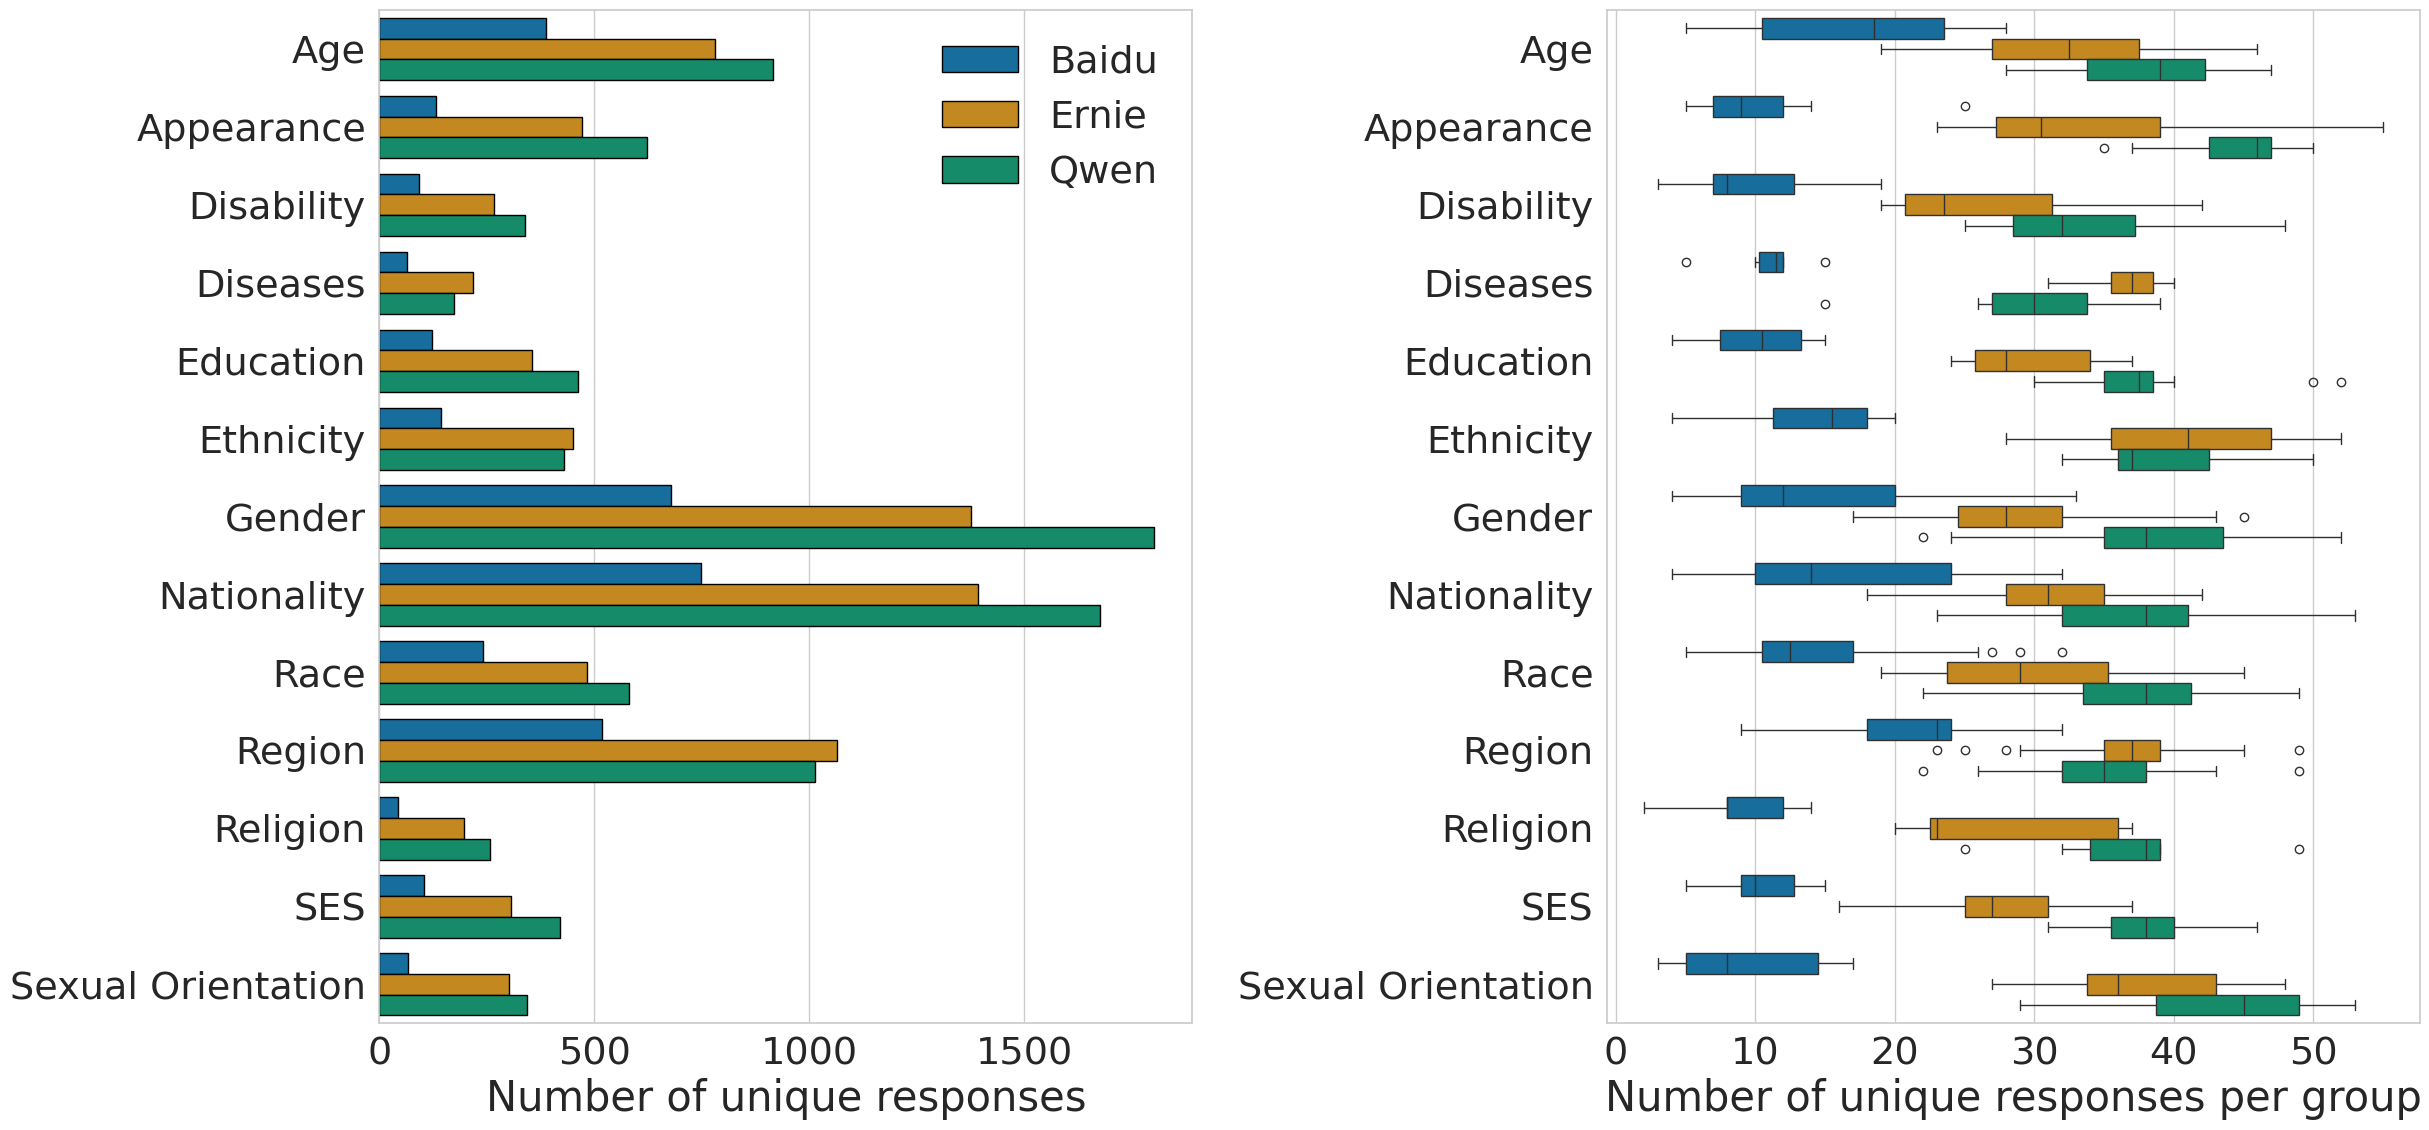

In [847]:
qwen_data = qwen.sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "json_response"]]
qwen_data["model"] = ["Qwen" for j in range(qwen_data.__len__())]

baidu_data = baidu[baidu.suggestion_starts_with_query].sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "response"]]
baidu_data = baidu_data.rename(columns={"response":"json_response"})
baidu_data["model"] = ["Baidu" for j in range(baidu_data.__len__())]

ernie_data = ernie.sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["category", "group_English"], sort=False).nunique().reset_index()[["category", "group_English", "json_response"]]
ernie_data["model"] = ["Ernie" for j in range(ernie_data.__len__())]

plot_data = pd.concat([qwen_data,ernie_data,baidu_data],ignore_index=True)



fig, axs = plt.subplots(1, 2, figsize = (25, 12))
ax = axs[0]
sns.barplot(ax=ax, y="category", order = order,  hue_order = ["Baidu", "Ernie", "Qwen"], edgecolor="black", x = "json_response", hue="model", data=plot_data.groupby(["category", "model"]).sum().reset_index(), palette="colorblind")
ax.legend(frameon=False)
ax.set_ylabel("")
ax.set_xlabel("Number of unique responses")
ax.set_yticks(range(13), group_ticks)

ax = axs[1]
sns.boxplot(ax=ax, y="category", x = "json_response", order = order, hue_order = ["Baidu", "Ernie", "Qwen"], legend=False, hue="model", data=plot_data, palette="colorblind")
#ax.legend()
ax.set_ylabel("")
ax.set_xlabel("Number of unique responses per group")
ax.set_yticks(range(13), group_ticks)

plt.tight_layout()

## Inconsistent results in Baidu

[(0.0, 1.0),
 Text(0, 0.5, ''),
 Text(0.5, 0, 'Proportion of inconsistent results in Baidu')]

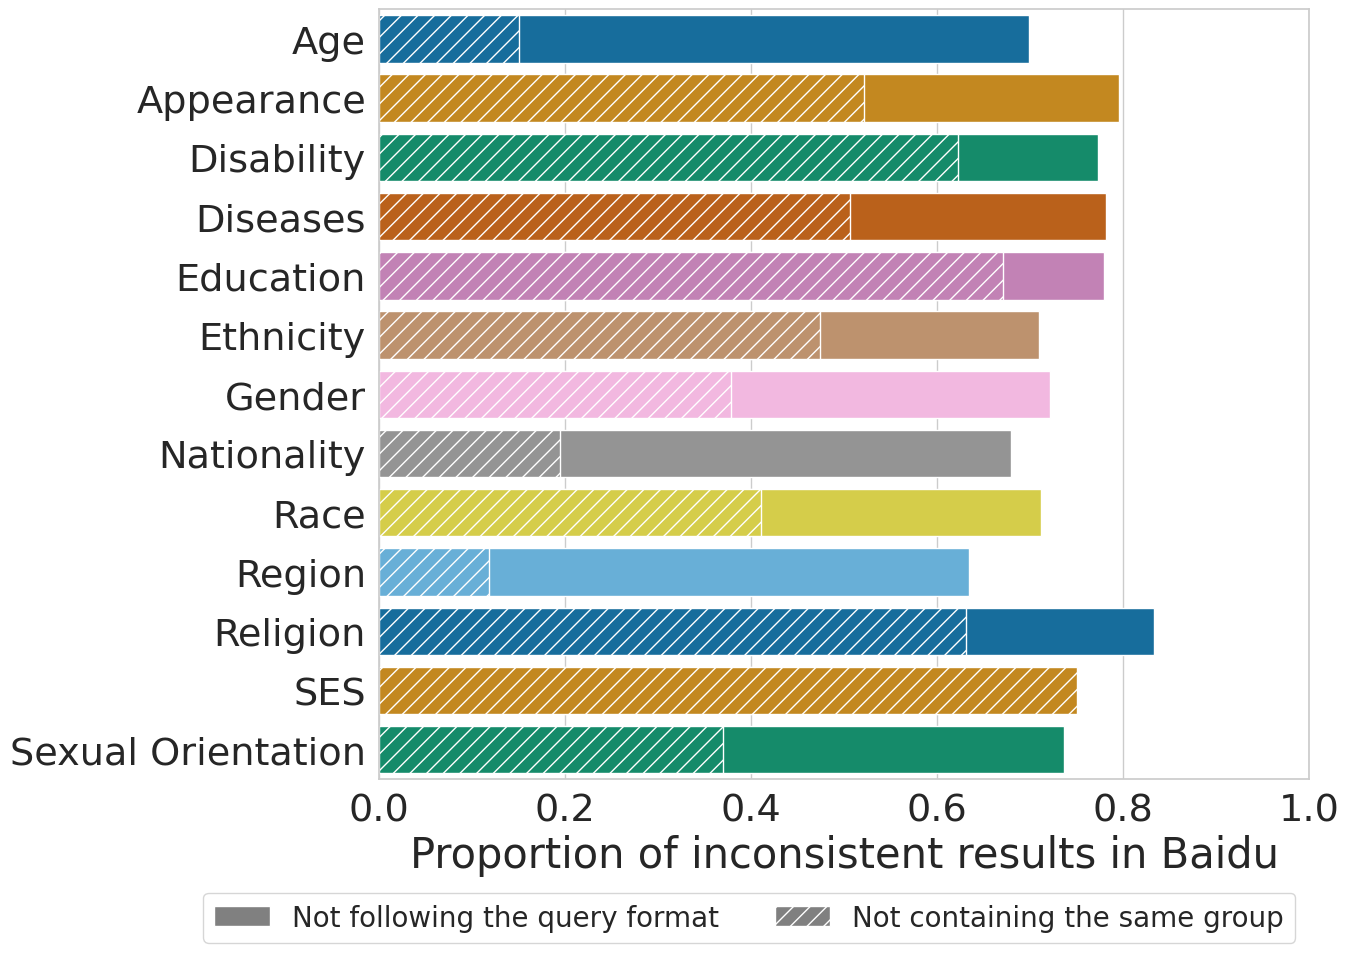

In [809]:
### social groups are not in responses 

# Define the function to calculate inverse proportions
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_response'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category
baidu = baidu.sort_values("category", key=lambda x: x.map(custom_dict))
grouped_baidu = baidu.groupby("category", sort=False)
inverse_proportions_baidu = calculate_category_inverse_proportions(grouped_baidu)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu',
        'Not Follow Query %': inverse_proportions_baidu[category]['Not Follow Query'],
        'Not Contain Group %': inverse_proportions_baidu[category]['Not Contain Group']
    })
    
df_plot_stacked_correct = pd.DataFrame(plot_data)
df_plot_stacked_correct = df_plot_stacked_correct.sort_values("Category", key=lambda x: x.map(custom_dict))

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Define the categories and palette
categories = df_plot_stacked_correct['Category']
palette = sns.color_palette("colorblind", len(categories))
hatches = ['//'] * len(categories)

# Plot each bar
for idx, category in enumerate(order):
    # Plot "Not Follow Query %" bars
    bar1 = sns.barplot(
        x='Not Follow Query %', 
        y='Category',
        order = order,
        data=df_plot_stacked_correct[df_plot_stacked_correct['Category'] == category],
        color=palette[idx], 
        edgecolor='w'
    )
    # Plot "Not Contain Group %" bars with hatches
    bar2 = sns.barplot(
        order = order,
        x='Not Contain Group %', 
        y='Category', 
        data=df_plot_stacked_correct[df_plot_stacked_correct['Category'] == category],
        color=palette[idx], 
        hatch=hatches[idx], 
        edgecolor='w'
    )

# Create a custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='grey', edgecolor='w', label='Not following the query format'),
    Patch(facecolor='grey', hatch='//', edgecolor='w', label='Not containing the same group')
]
# Customize the legend
# legend = ax.legend(title='Metric', fontsize='xx-small', title_fontsize='xx-small', loc=6, frameon=False)
# Set axis labels and limits
ax.set_yticks(range(13), group_ticks)
ax.legend(handles=legend_elements, bbox_to_anchor=(1, -0.18), ncol=2, fontsize=20, fancybox=True, loc = 'center right')
ax.set(xlim=(0, 1), ylabel="", xlabel="Proportion of inconsistent results in Baidu")
#sns.despine(left=True, bottom=True)
#plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
# Show the plot
#plt.savefig("Figure/inconsistent_query.svg",format="svg")
#plt.show()
#plt.close()
#plt.tight_layout()

# Diversity

## jaccard similarity heatmap (groups)


In [877]:
# Group the data by category and create sets of response values
group_responses_ernie = ernie.sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(['group_English', 'category'], sort=False)['json_response'].apply(set).reset_index()
group_responses_qwen = qwen.sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(['group_English', 'category'], sort=False)['json_response'].apply(set).reset_index()


In [878]:
# Define a function to calculate the Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [879]:
similarity_matrix_ernie = pd.DataFrame(index=group_responses_ernie['group_English'], columns=group_responses_ernie['group_English'])

category_similarity_ernie_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_ernie.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_ernie.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['json_response'], row2['json_response'])
        similarity_matrix_ernie.loc[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            # category_similarity_ernie_df.append({'category':cat2, 'value':value, 'kind':'Different Category'}) 
category_similarity_ernie_df = pd.DataFrame(category_similarity_ernie_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_ernie = similarity_matrix_ernie.astype(float)


/tmp/ipykernel_383676/1237729652.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


Text(0.5, 1.05, 'Output diversity in Ernie')

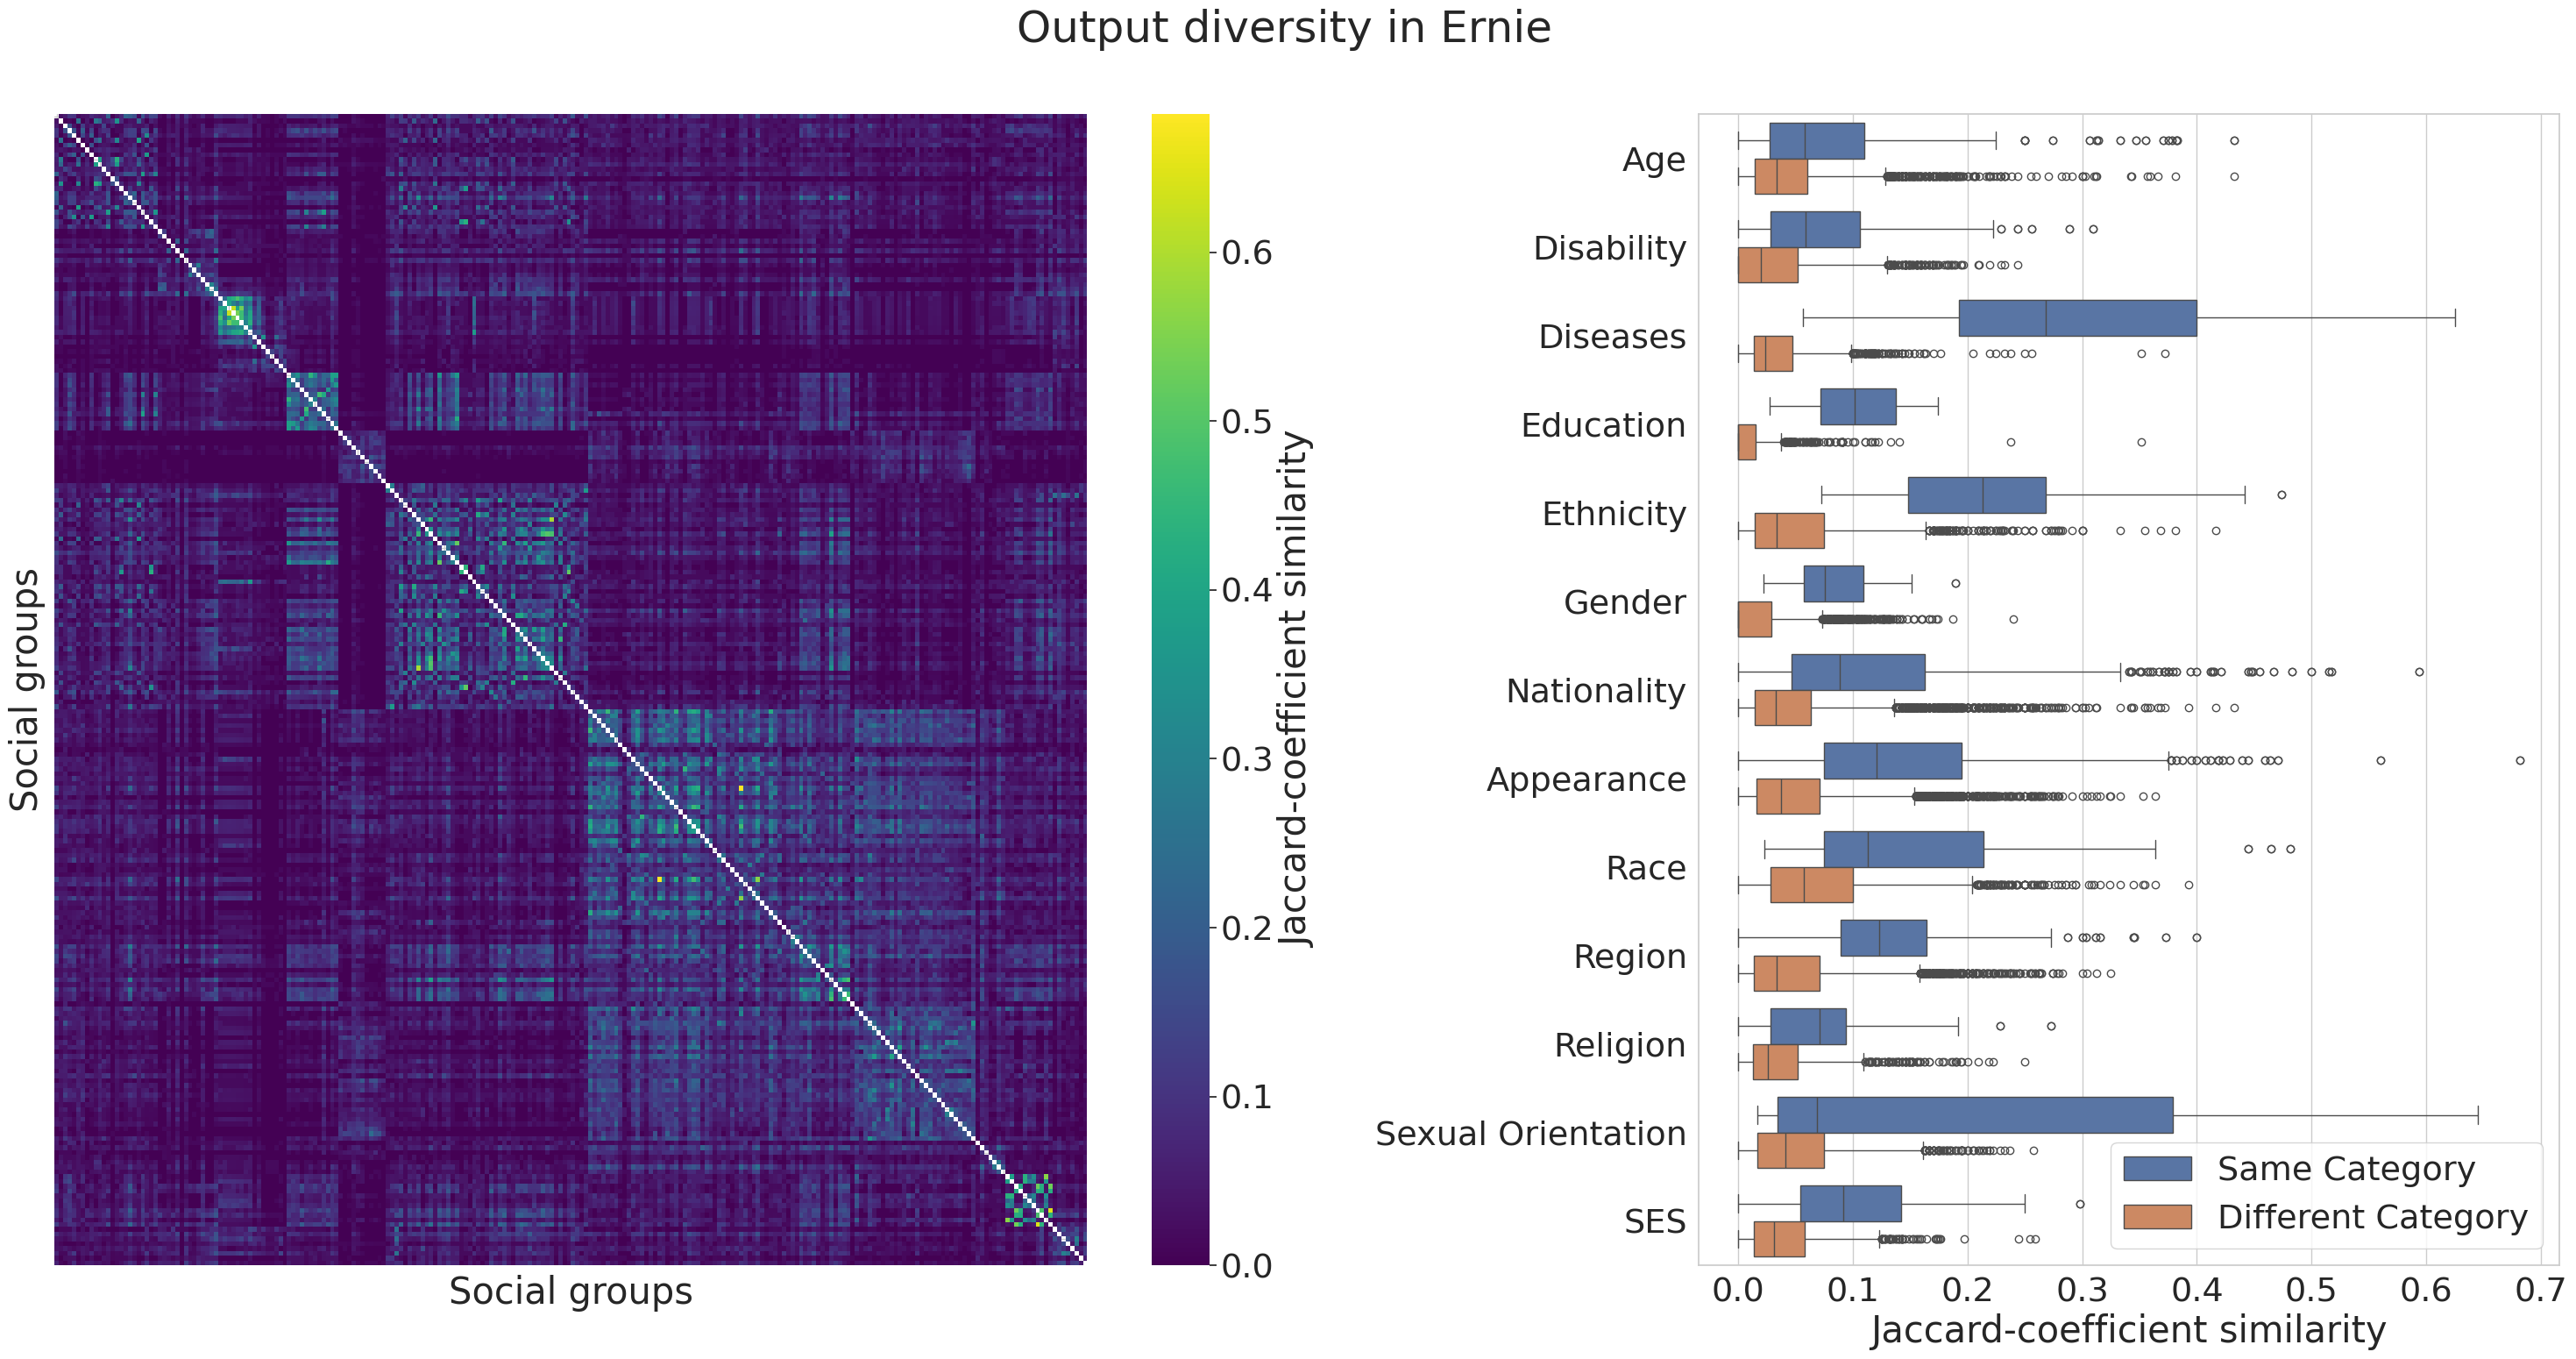

In [880]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_ernie,
    cmap="viridis",
    mask = similarity_matrix_ernie == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_ernie_df)
ax.legend(title="")
ax.set_yticklabels(yticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()

plt.suptitle("Output diversity in Ernie", y=1.05)

In [881]:
similarity_matrix_qwen = pd.DataFrame(index=group_responses_qwen['group_English'], columns=group_responses_qwen['group_English'])

category_similarity_qwen_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_qwen.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_qwen.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['json_response'], row2['json_response'])
        similarity_matrix_qwen.loc[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_qwen_df.append({'category':cat2, 'value':value, 'kind':'Different Category'}) 
category_similarity_qwen_df = pd.DataFrame(category_similarity_qwen_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_qwen = similarity_matrix_qwen.astype(float)


/tmp/ipykernel_383676/3005114105.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


Text(0.5, 1.05, 'Output diversity in Qwen')

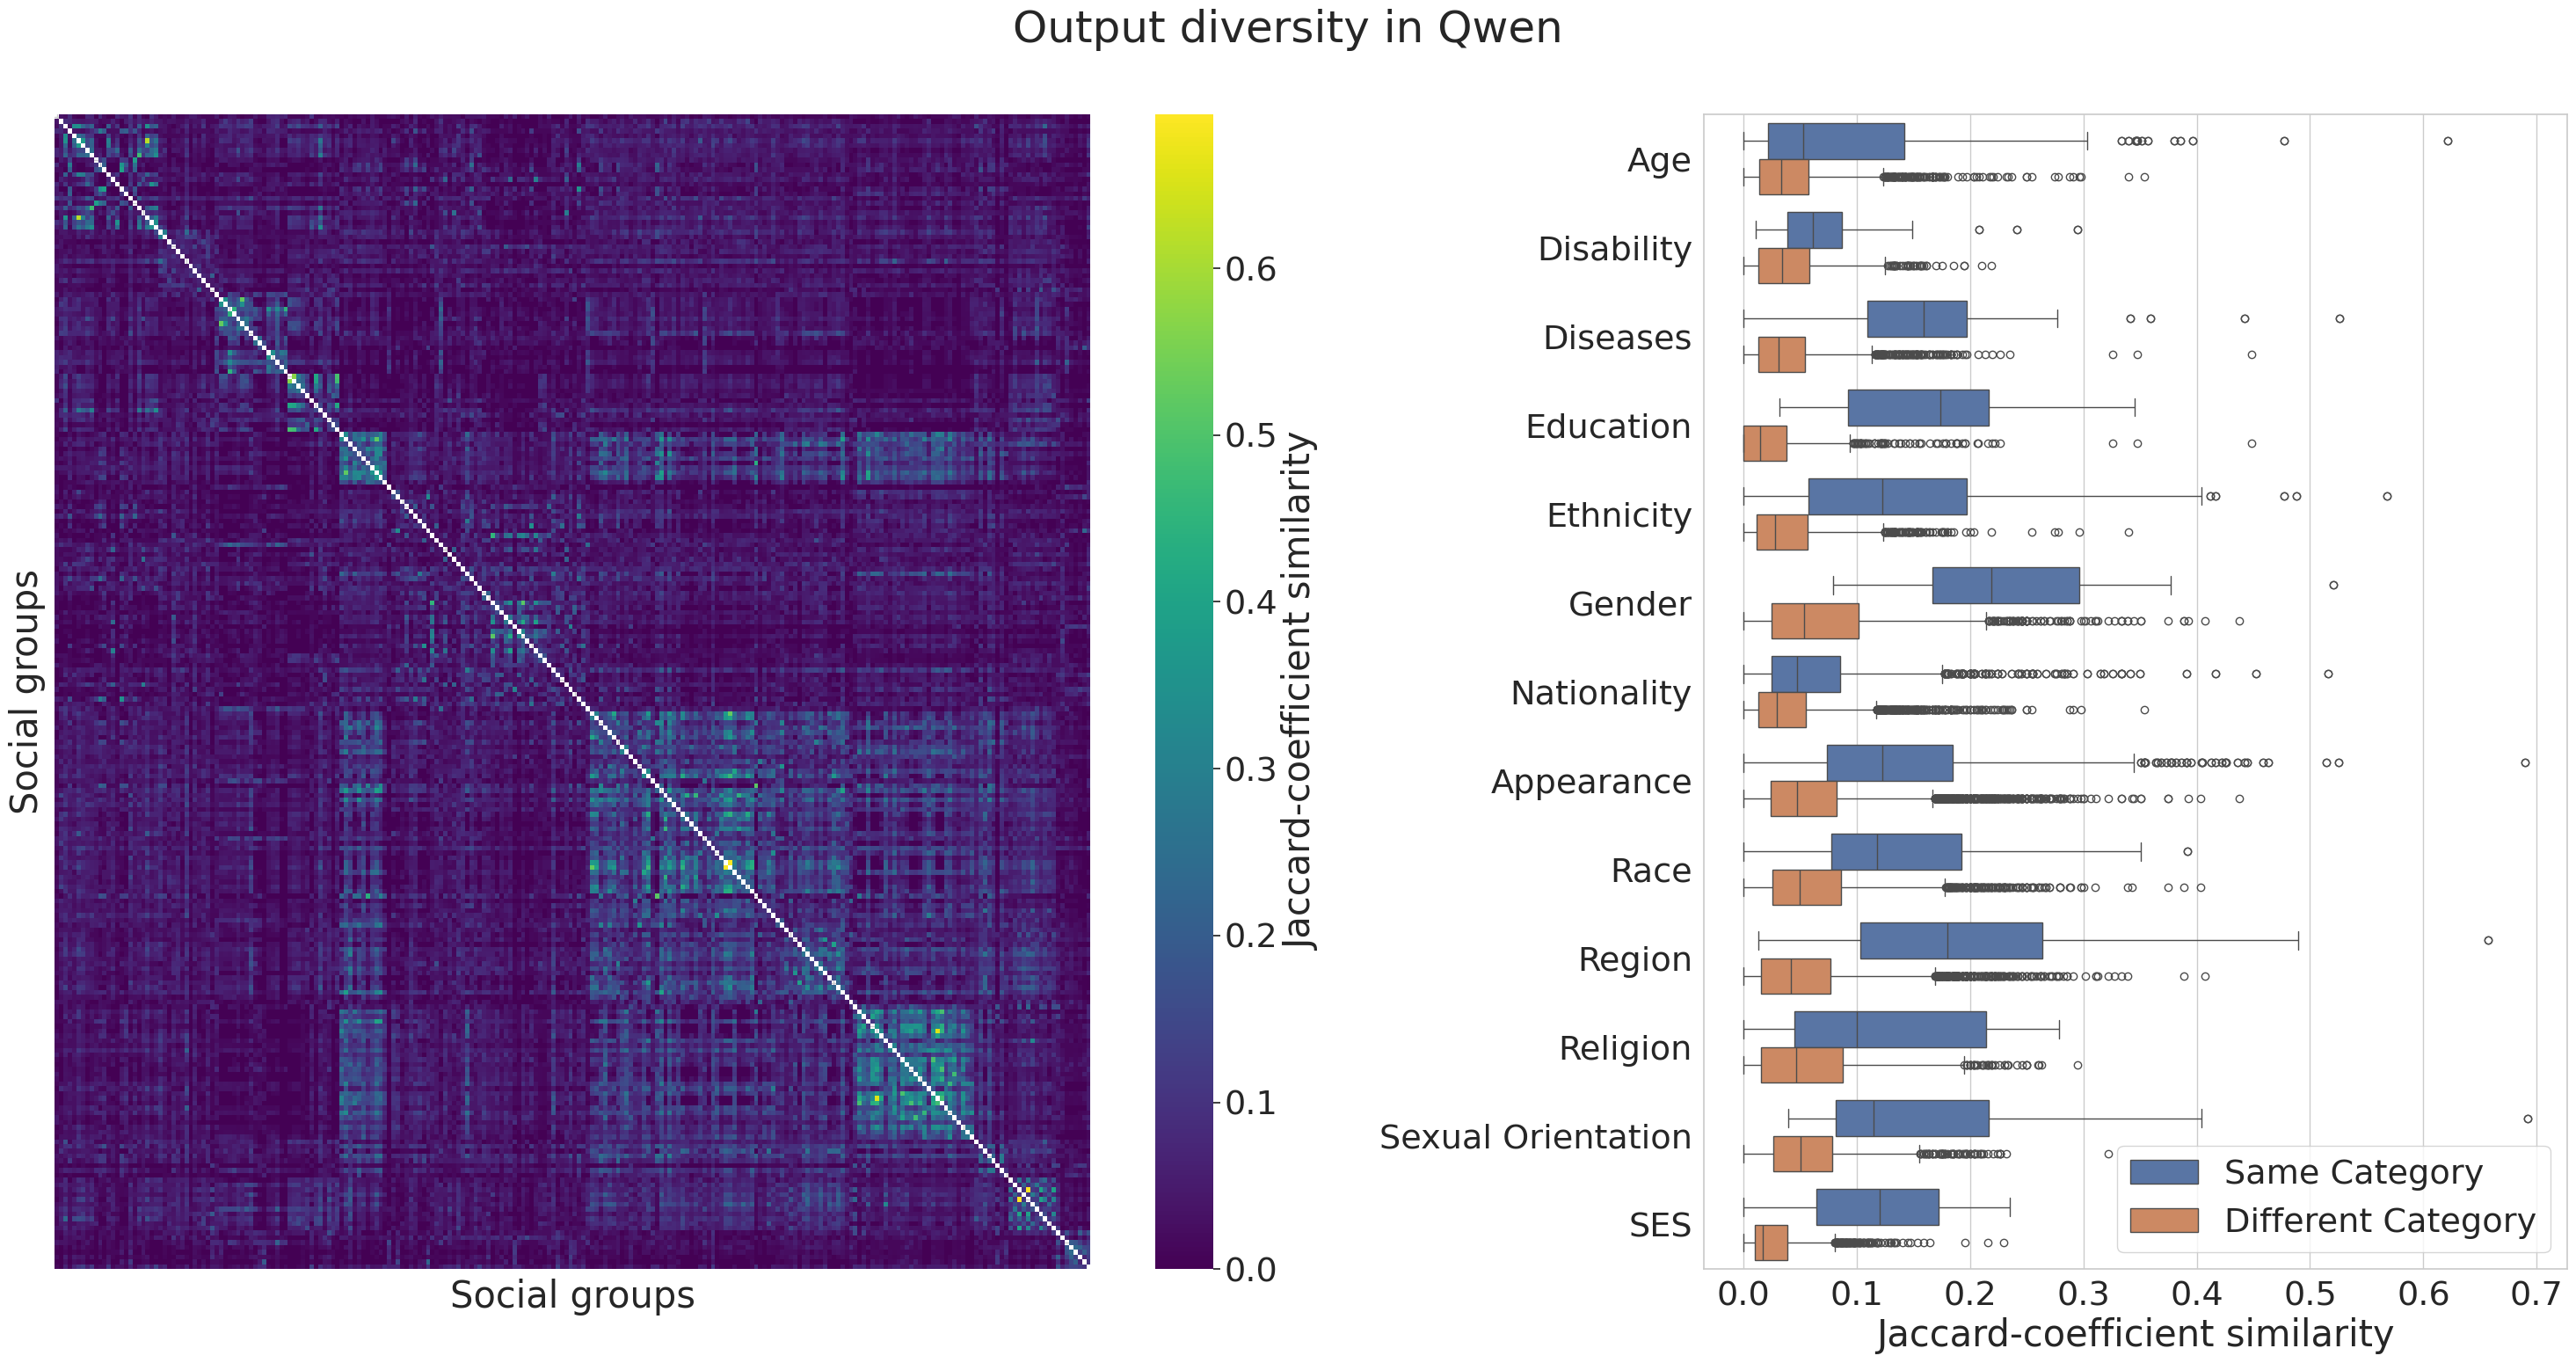

In [882]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_qwen,
    cmap="viridis",
    mask = similarity_matrix_qwen == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_qwen_df)
ax.legend(title="")
ax.set_yticklabels(yticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()
plt.suptitle("Output diversity in Qwen", y=1.05)

In [883]:
group_responses_baidu = baidu[baidu.suggestion_starts_with_query].sort_values("group_English").sort_values("category", key=lambda x: x.map(custom_dict)).groupby(["group_English", "category"], sort=False)["response_values"].apply(set).reset_index()
similarity_matrix_baidu = pd.DataFrame(index=group_responses_baidu['group_English'], columns=group_responses_baidu['group_English'])

category_similarity_baidu_df = []
# Calculate Jaccard similarity for the upper triangle
for index1, row1 in group_responses_baidu.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_baidu.iterrows():
#         if index1 < index2:  # Calculate only for upper triangle
        cat2 = row2.category
        value = jaccard_similarity(row1['response_values'], row2['response_values'])
        similarity_matrix_baidu.loc[row1['group_English'], row2['group_English']] = value
        if value == 1 and index1 != index2:
            print(f"{row1.group_English} vs {row2.group_English}")
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_baidu_df.append({'category':cat2, 'value':value, 'kind':'Different Category'})
category_similarity_baidu_df = pd.DataFrame(category_similarity_baidu_df)
        
# # Mask the lower triangle
#mask_ernie = np.tril(np.ones_like(similarity_matrix_ernie, dtype=bool))

similarity_matrix_baidu = similarity_matrix_baidu.astype(float)


Part-time Graduates vs Graduates from Ordinary First-Tier Universities
Part-time Graduates vs Graduates from Ordinary Overseas Universities
Graduates from Ordinary First-Tier Universities vs Part-time Graduates
Graduates from Ordinary First-Tier Universities vs Graduates from Ordinary Overseas Universities
Graduates from Ordinary Overseas Universities vs Part-time Graduates
Graduates from Ordinary Overseas Universities vs Graduates from Ordinary First-Tier Universities
Tujia vs Zhuang
Tujia vs Ecuadorians
Tujia vs African Americans
Yunnan Ethnic Minorities vs Latino Americans
Zhuang vs Tujia
Zhuang vs Ecuadorians
Zhuang vs African Americans
Indonesians vs Senegalese
Senegalese vs Indonesians
Ethiopians vs Hispanic Americans
Ethiopians vs Hong Kong Residents
Ethiopians vs Non-First Tier City Residents
Ethiopians vs People from low-income families
Ecuadorians vs Tujia
Ecuadorians vs Zhuang
Ecuadorians vs African Americans
Latino Americans vs Yunnan Ethnic Minorities
African Americans vs 

/tmp/ipykernel_383676/2291357792.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


Text(0.5, 1.05, 'Output diversity in Baidu')

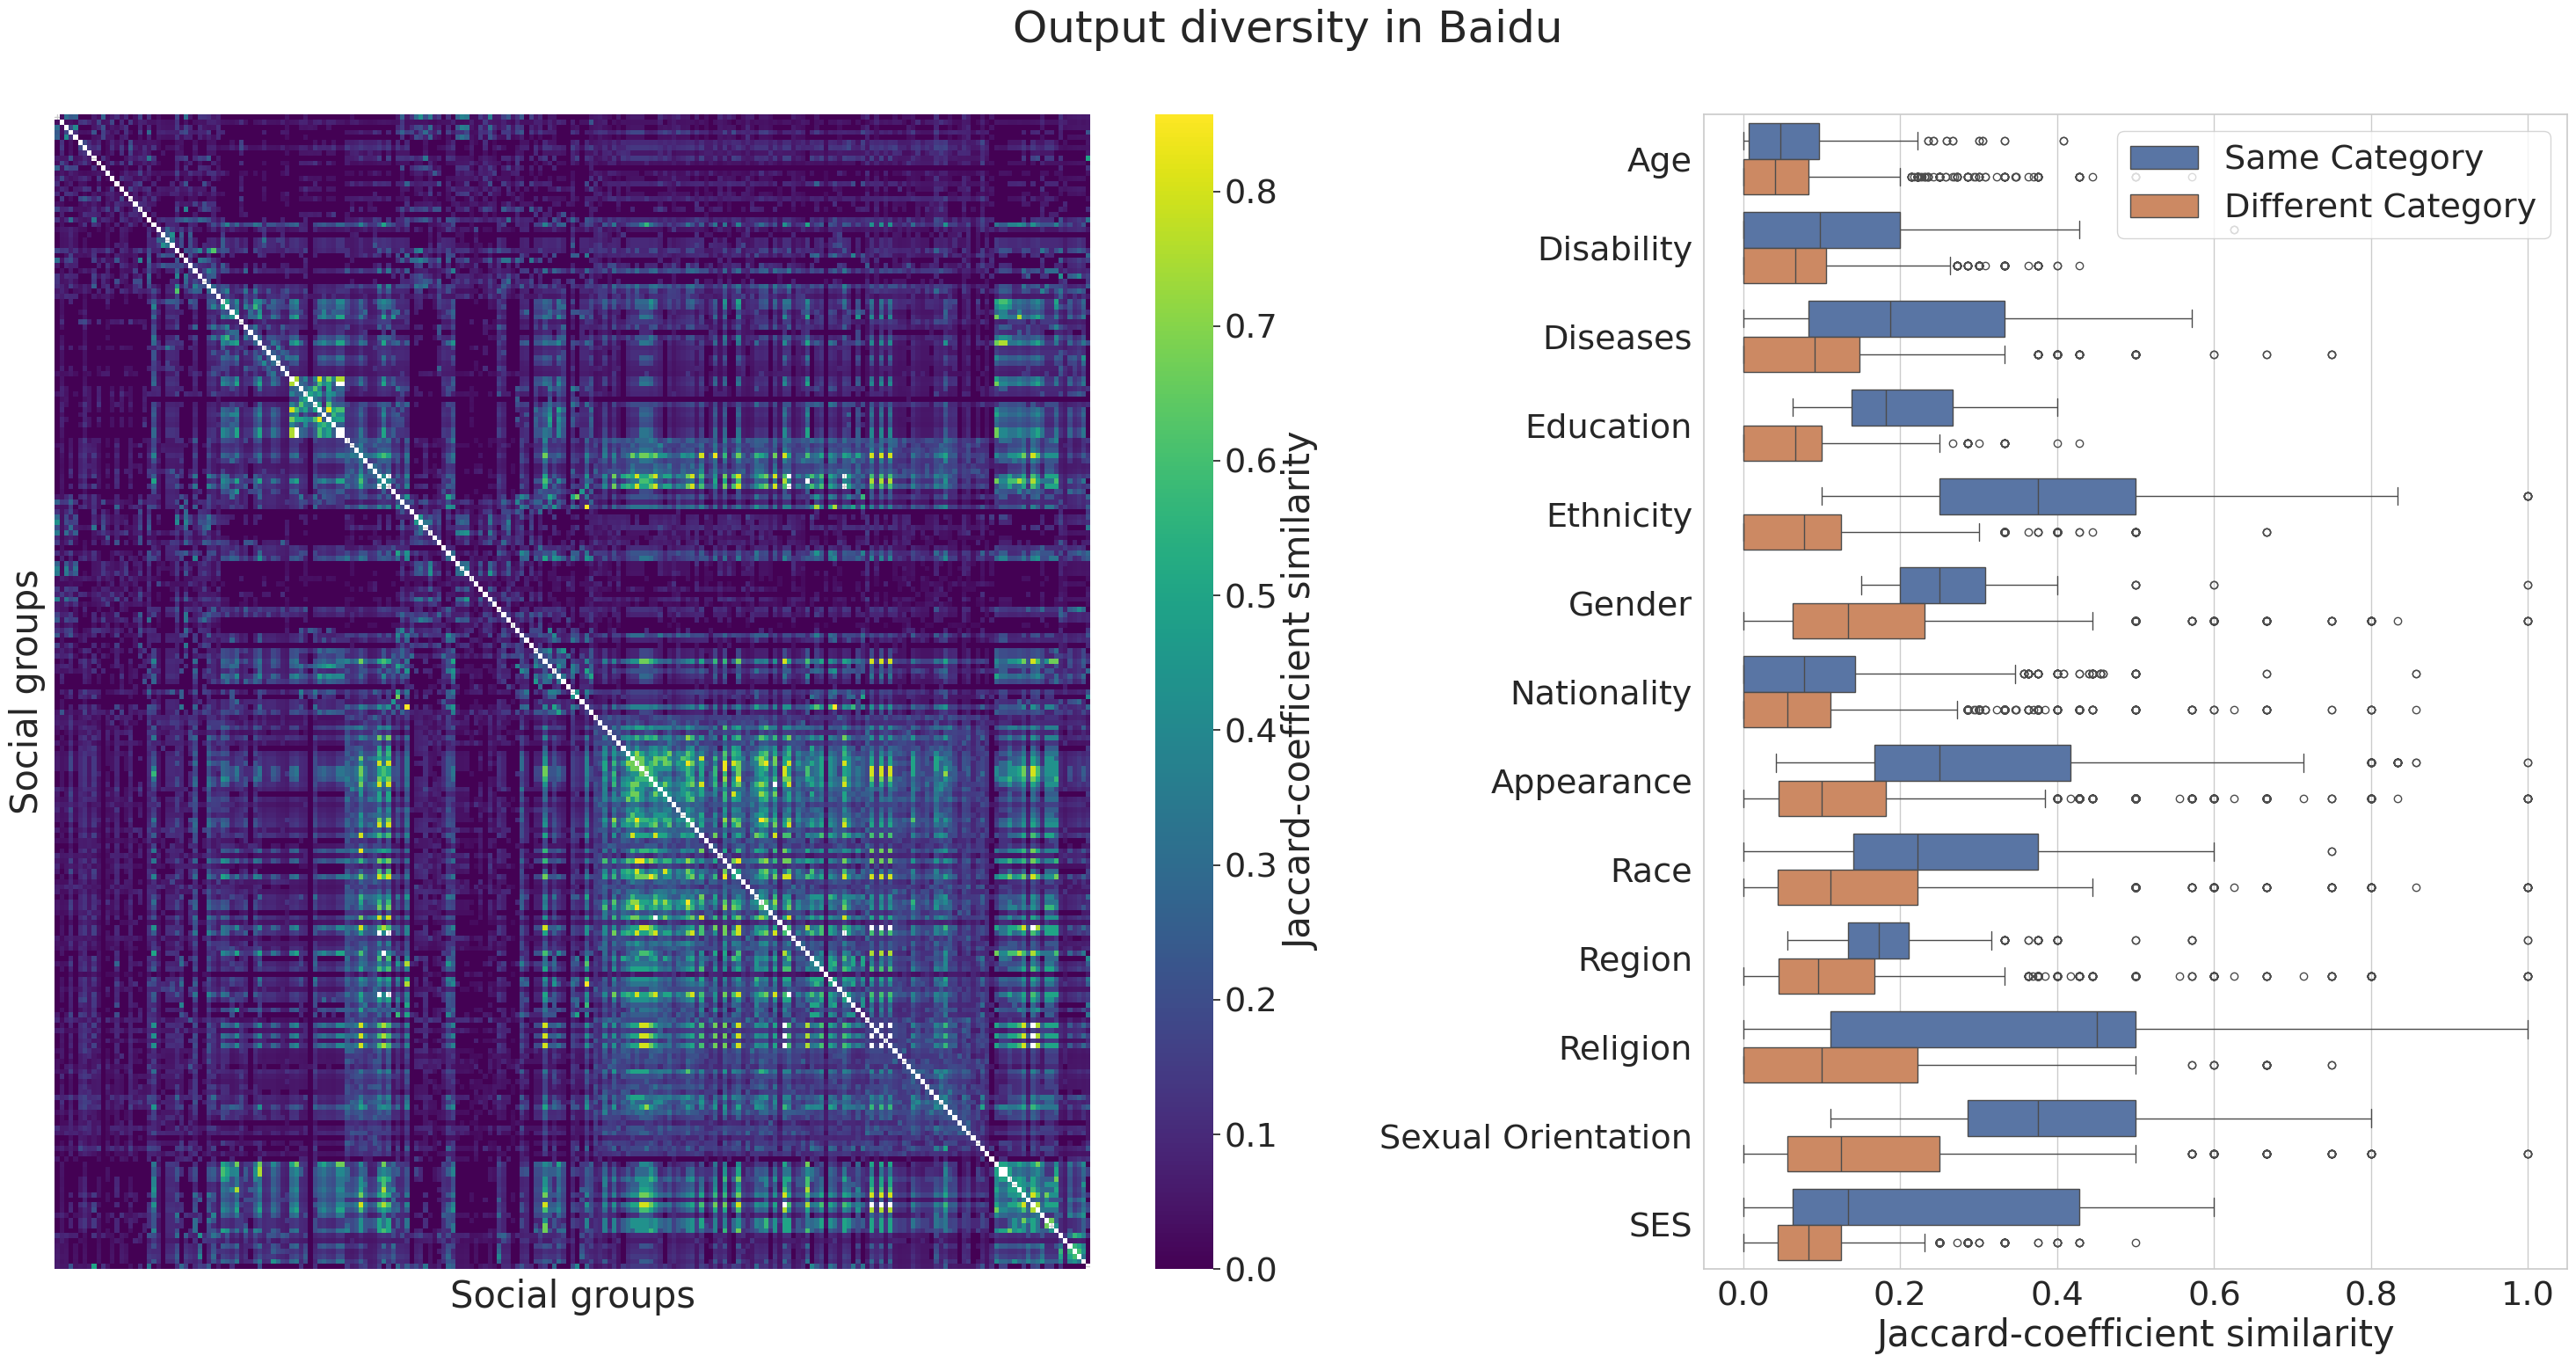

In [884]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15), width_ratios=[3, 2])
ax = axs[0]

g = sns.heatmap(
    ax = ax,
    data = similarity_matrix_baidu,
    cmap="viridis",
    mask = similarity_matrix_baidu == 1,
    cbar_kws={'label': 'Jaccard-coefficient similarity'}
)
#ax.set_title("Ernie Jaccard-coefficient similarity")
ax.set_ylabel("Social groups")
ax.set_xlabel("Social groups")
ax.tick_params(axis='both', which='both', length=0)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axs[1]
sns.boxplot(ax=ax, y="category", hue="kind", x = "value", data=category_similarity_baidu_df)
ax.legend(title="")
ax.set_yticklabels(yticks)
ax.set_ylabel("")
ax.set_xlabel("Jaccard-coefficient similarity")
plt.tight_layout()
plt.suptitle("Output diversity in Baidu", y=1.05)

/tmp/ipykernel_383676/2004709944.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(group_ticks)


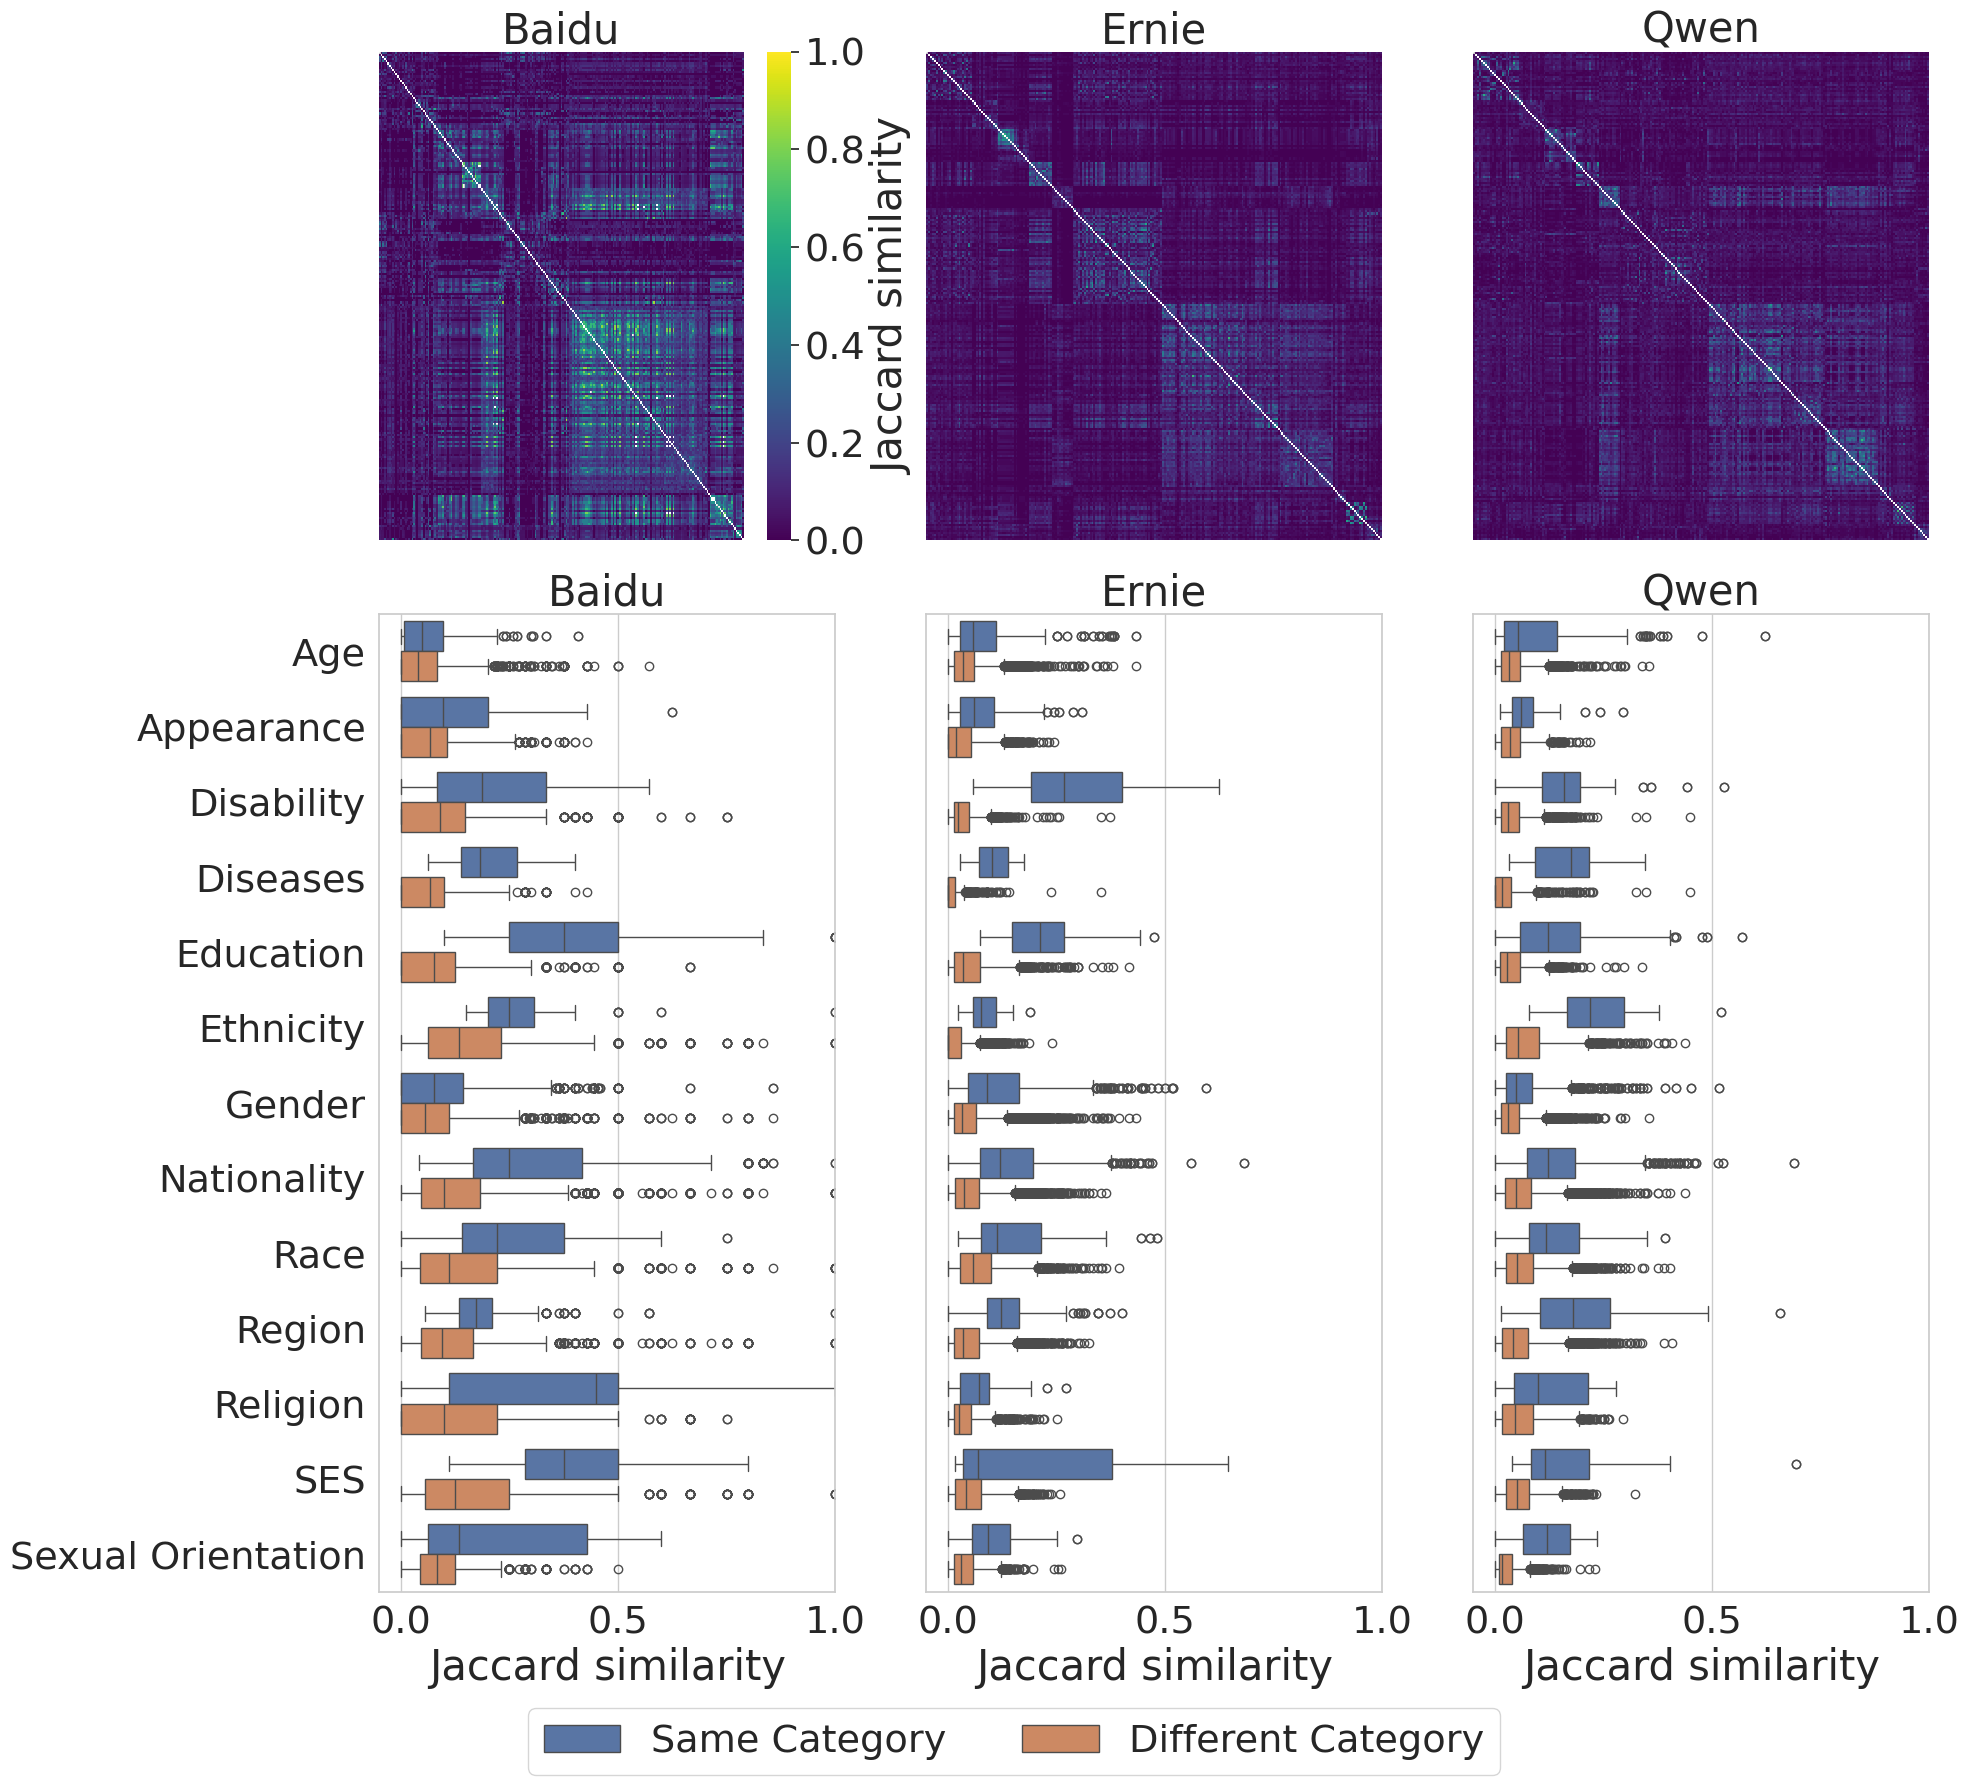

In [885]:
fig, axs = plt.subplot_mosaic("ABC;DEF", figsize=(20, 20), height_ratios=[1, 2])

#axs["E"].sharey(axs['D'])    
#axs["F"].sharey(axs['D'])    

labels = [["A", "D"], ["B", "E"], ["C", "F"]]

for label, model, data in zip(labels, ["Baidu", "Ernie", "Qwen"], [[similarity_matrix_baidu, category_similarity_baidu_df],
                                                   [similarity_matrix_ernie, category_similarity_ernie_df],
                                                   [similarity_matrix_qwen, category_similarity_qwen_df]]):
    ax = axs[label[0]]
    sns.heatmap(
        ax = ax,
        data = data[0],
        cmap="viridis",
        mask = data[0] == 1,
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Jaccard similarity'},
        cbar = False if model != "Baidu" else True
    )
    ax.set_title(model)
    
    #ax.set_title("Ernie Jaccard-coefficient similarity")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax = axs[label[1]]
    ax.set_title(model)
    sns.boxplot(ax=ax, y="category", hue="kind", x = "value", legend = False if model in ["Ernie", "Qwen"] else True, 
                data=data[1])
    if model == "Baidu":
        ax.legend(title="", bbox_to_anchor=(2.5, -0.1), ncols=2)
        ax.set_yticklabels(group_ticks)
    if model in ["Ernie", "Qwen"]:
        ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("Jaccard similarity")
    ax.set_xlim(-0.05, 1)
    

plt.subplots_adjust(hspace=0.1)
#plt.tight_layout()

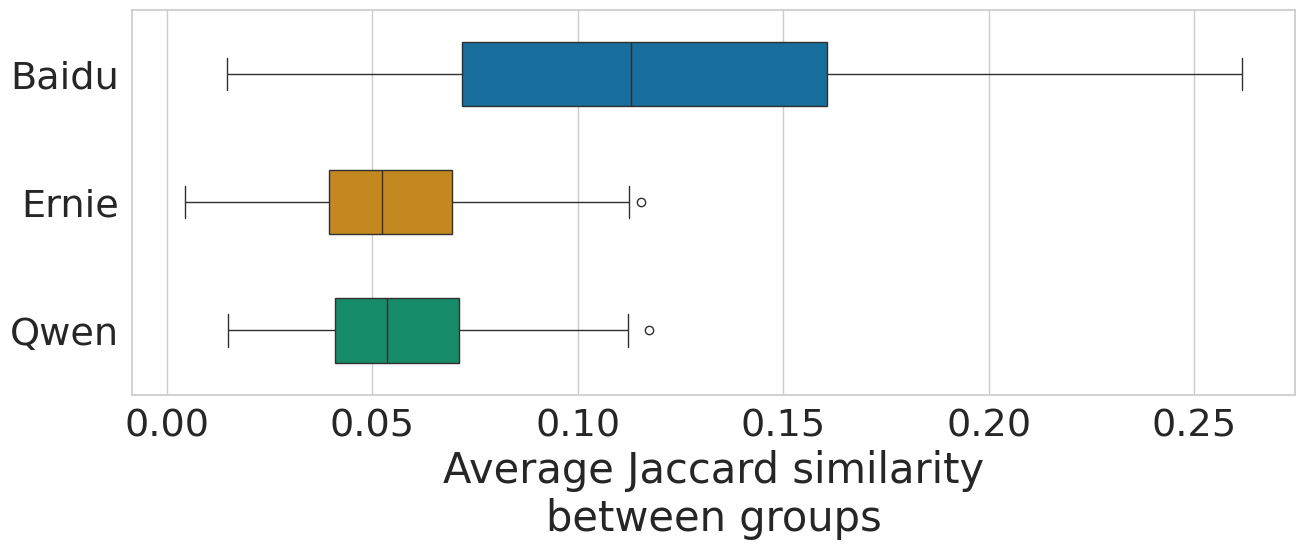

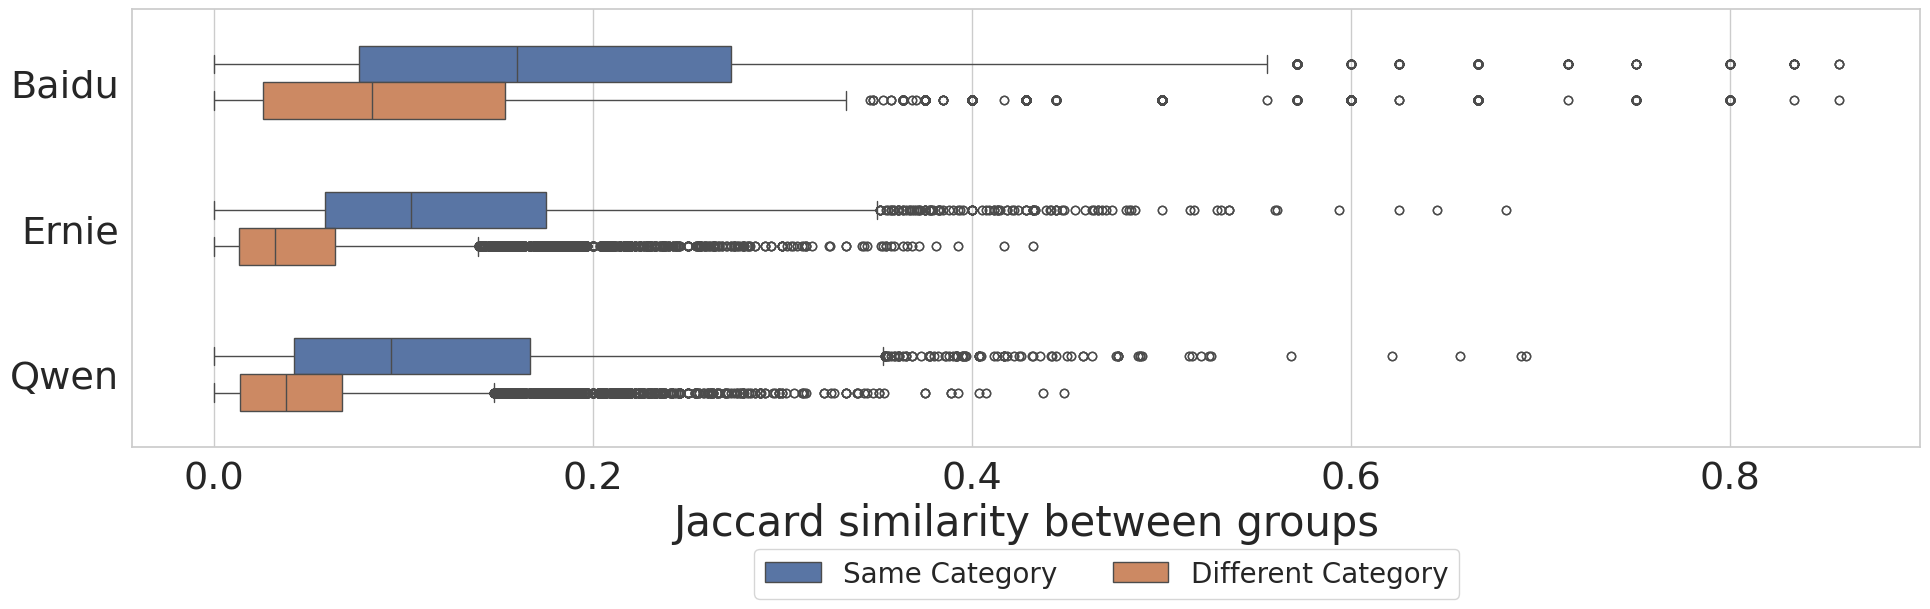

In [956]:
fig, ax = plt.subplots(figsize=(15, 5))

dfs = []
for label, data in zip(["Baidu", "Ernie", "Qwen"], [similarity_matrix_baidu, similarity_matrix_ernie, similarity_matrix_qwen]):
    df = pd.DataFrame()
    df["value"] = data[data!=1].mean().values
    df["label"] = [label for j in range(df.__len__())]
    dfs.append(df)
dfs = pd.concat(dfs)

# plt.title("Similarity of generated output across groups")
sns.boxplot(y="label", x="value", data=dfs, width=.5,  palette="colorblind")
plt.xlabel("Average Jaccard similarity\nbetween groups")
plt.ylabel("")

fig, ax = plt.subplots(figsize=(20, 7))

category_similarity_baidu_df["model"] = ["Baidu" for j in range(category_similarity_baidu_df.__len__())]
category_similarity_ernie_df["model"] = ["Ernie" for j in range(category_similarity_ernie_df.__len__())]
category_similarity_qwen_df["model"] = ["Qwen" for j in range(category_similarity_qwen_df.__len__())]

dfs = pd.concat([category_similarity_baidu_df, category_similarity_ernie_df, category_similarity_qwen_df])
dfs = dfs[dfs.value != 1]

#plt.title("Semantic similarity across groups")
sns.boxplot(y="model", x="value", hue="kind", data=dfs, width=.5)
plt.xlabel("Jaccard similarity between groups")
plt.ylabel("")
plt.legend(title="", bbox_to_anchor=(0.75, -0.2), ncol=2, fontsize=20, fancybox=True)

plt.tight_layout()


## synonyms

In [916]:
import json

# Function to expand a set with its synonyms
def expand_with_synonyms(response_set, synonyms_dict):
    expanded_set = set(response_set)
    for word in response_set:
        if word in synonyms_dict:
            expanded_set.update(synonyms_dict[word])
    return expanded_set

with open('data/synonyms_expanded_narrow.json', 'r', encoding='utf-8') as f:
    synonyms_dict = json.load(f)

synonym_similarity_matrix_ernie = pd.DataFrame(index=group_responses_ernie['group_English'], columns=group_responses_ernie['group_English'])

category_synonym_similarity_ernie_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_ernie.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_ernie.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['json_response'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['json_response'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_ernie.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_ernie_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
            #category_similarity_baidu_df.append({'category':cat2, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_ernie_df = pd.DataFrame(category_similarity_ernie_df)
    
synonym_similarity_matrix_baidu = pd.DataFrame(index=group_responses_baidu['group_English'], columns=group_responses_baidu['group_English'])

category_synonym_similarity_baidu_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_baidu.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_baidu.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['response_values'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['response_values'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_baidu.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_baidu_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_baidu_df = pd.DataFrame(category_synonym_similarity_baidu_df)

synonym_similarity_matrix_qwen = pd.DataFrame(index=group_responses_qwen['group_English'], columns=group_responses_qwen['group_English'])

category_synonym_similarity_qwen_df = []
# Calculate synonym-based similarity for the upper triangle
for index1, row1 in group_responses_qwen.iterrows():
    cat1 = row1.category
    for index2, row2 in group_responses_qwen.iterrows():
        cat2 = row2.category
        expanded_set1 = expand_with_synonyms(row1['json_response'], synonyms_dict)
        expanded_set2 = expand_with_synonyms(row2['json_response'], synonyms_dict)
        value = jaccard_similarity(expanded_set1, expanded_set2)
        synonym_similarity_matrix_qwen.at[row1['group_English'], row2['group_English']] = value
        if cat1 == cat2:
            if index1 == index2:
                continue
            category_synonym_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Same Category'})
        else:
            category_synonym_similarity_qwen_df.append({'category':cat1, 'value':value, 'kind':'Different Category'})
category_synonym_similarity_qwen_df = pd.DataFrame(category_synonym_similarity_qwen_df)
             
    
synonym_similarity_matrix_baidu = synonym_similarity_matrix_baidu.astype(float)    
synonym_similarity_matrix_ernie = synonym_similarity_matrix_ernie.astype(float)    
synonym_similarity_matrix_qwen = synonym_similarity_matrix_qwen.astype(float)    


In [917]:

category_synonym_similarity_baidu_df["model"] = ["Baidu" for j in range(category_synonym_similarity_baidu_df.__len__())]
category_synonym_similarity_ernie_df["model"] = ["Ernie" for j in range(category_synonym_similarity_ernie_df.__len__())]
category_synonym_similarity_qwen_df["model"] = ["Qwen" for j in range(category_synonym_similarity_qwen_df.__len__())]


Text(0.5, 1.0, 'Qwen')

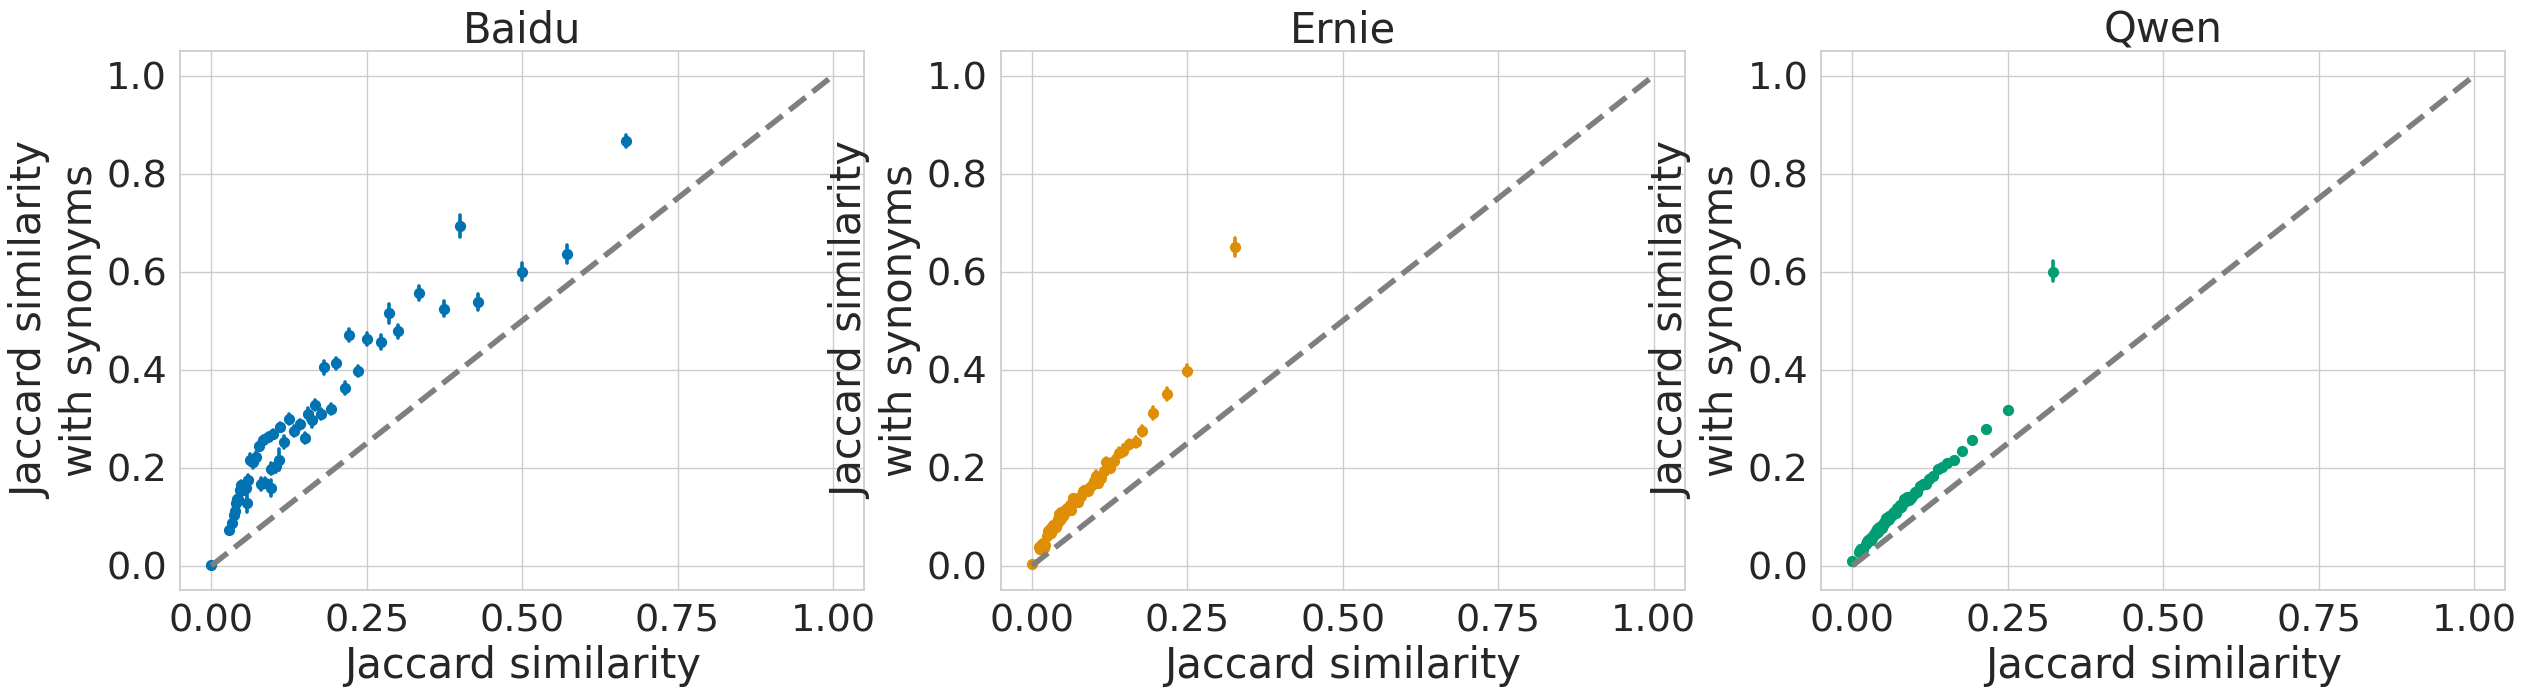

In [950]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

colors = sns.color_palette("colorblind", 3)

ax = axs[0]
y = synonym_similarity_matrix_baidu.values.flatten()
x = similarity_matrix_baidu.values.flatten()
sns.regplot(ax=ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[0])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Baidu")

ax = axs[1]
y = synonym_similarity_matrix_ernie.values.flatten()
x = similarity_matrix_ernie.values.flatten()
sns.regplot(ax=ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[1])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Ernie")

ax = axs[2]
y = synonym_similarity_matrix_qwen.values.flatten()
x = similarity_matrix_qwen.values.flatten()
sns.regplot(ax= ax, x=x, y=y, x_bins = 100, fit_reg = False, color=colors[2])
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("Jaccard similarity\nwith synonyms")
ax.set_title("Qwen")


/tmp/ipykernel_383676/1882839375.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(group_ticks)
/tmp/ipykernel_383676/1882839375.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_ticks, rotation=90)
/tmp/ipykernel_383676/1882839375.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_ticks, rotation=90)
/tmp/ipykernel_383676/1882839375.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_ticks, rotation=90)


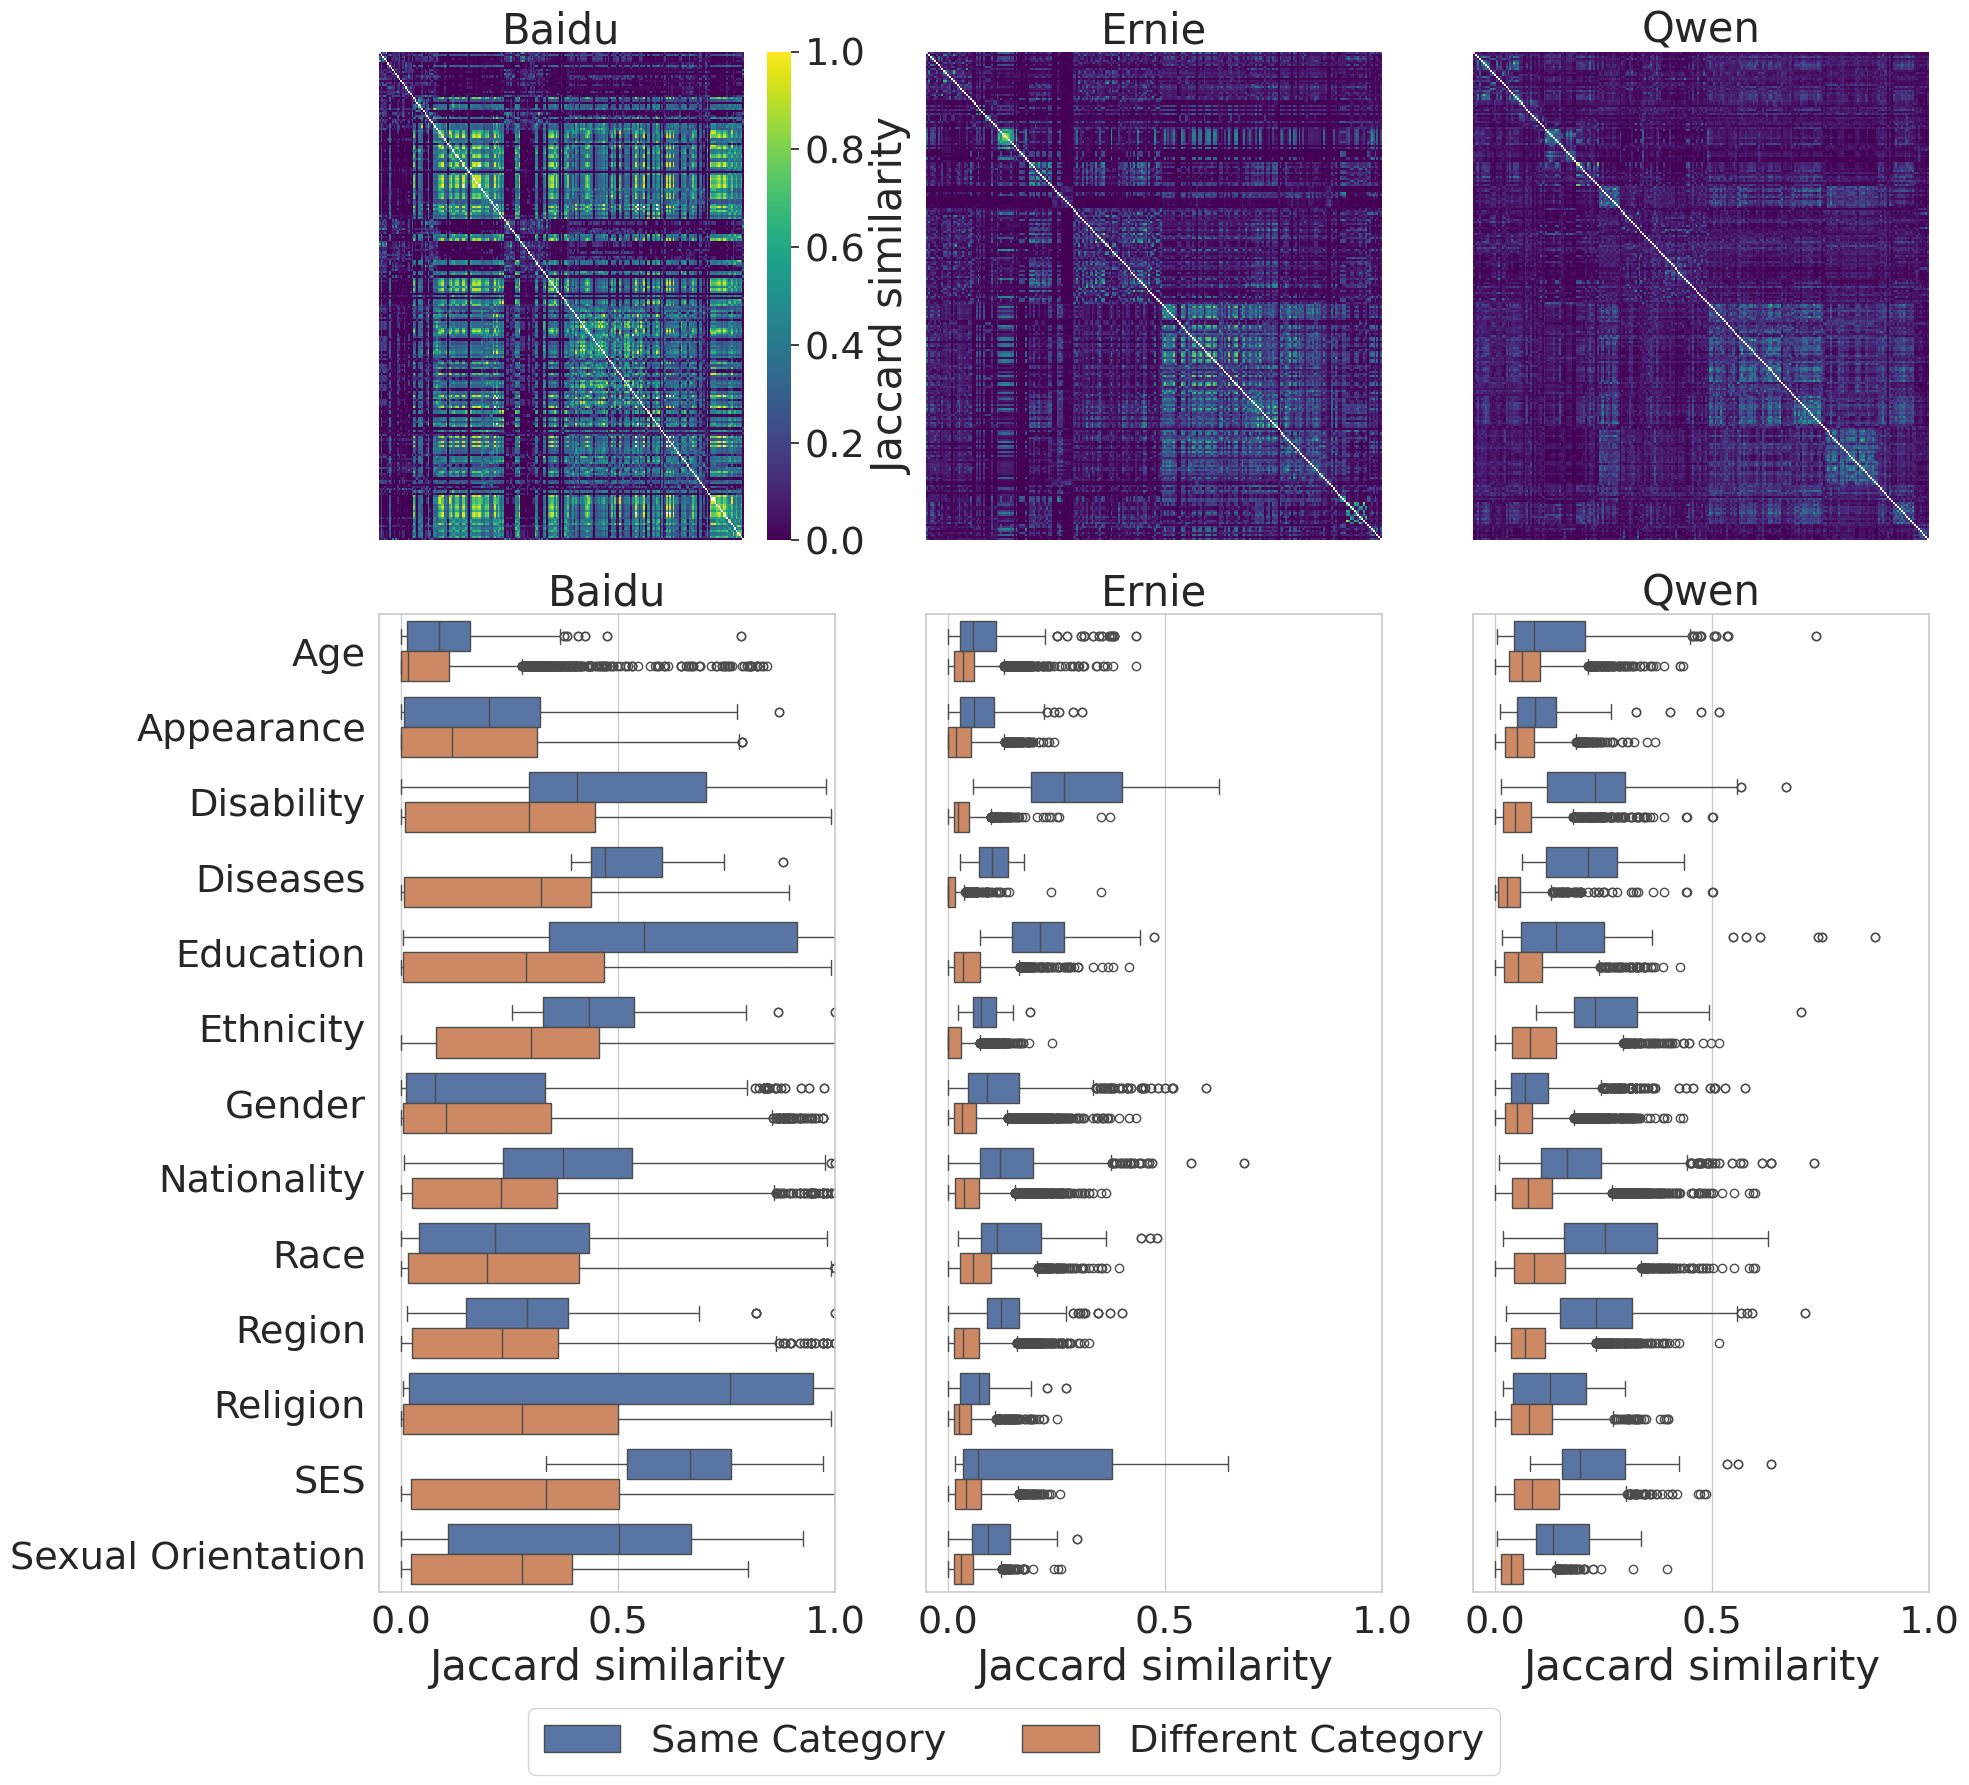

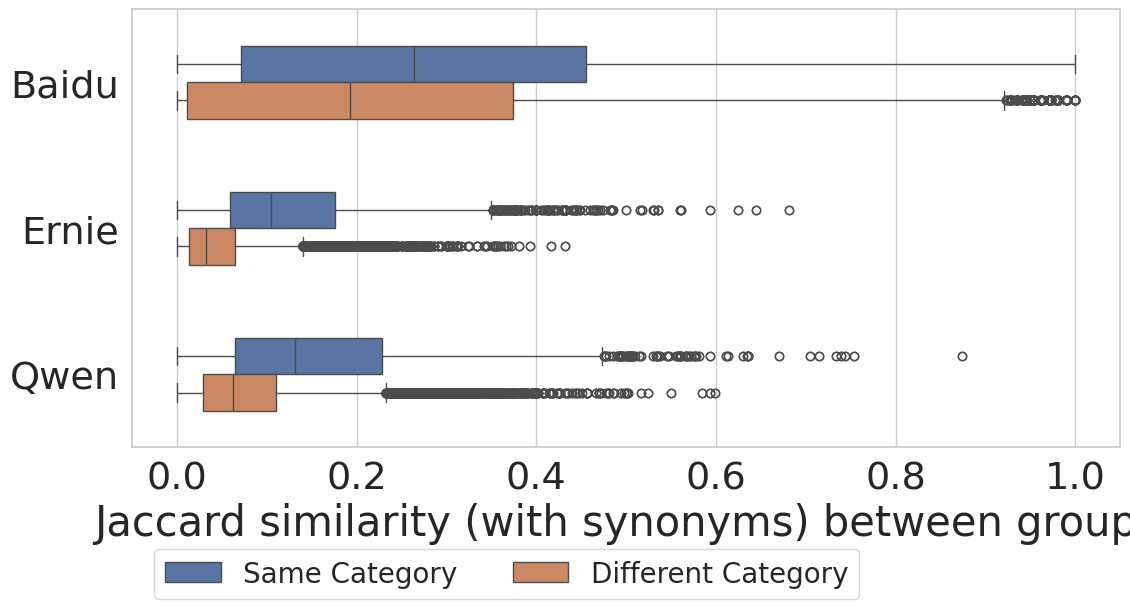

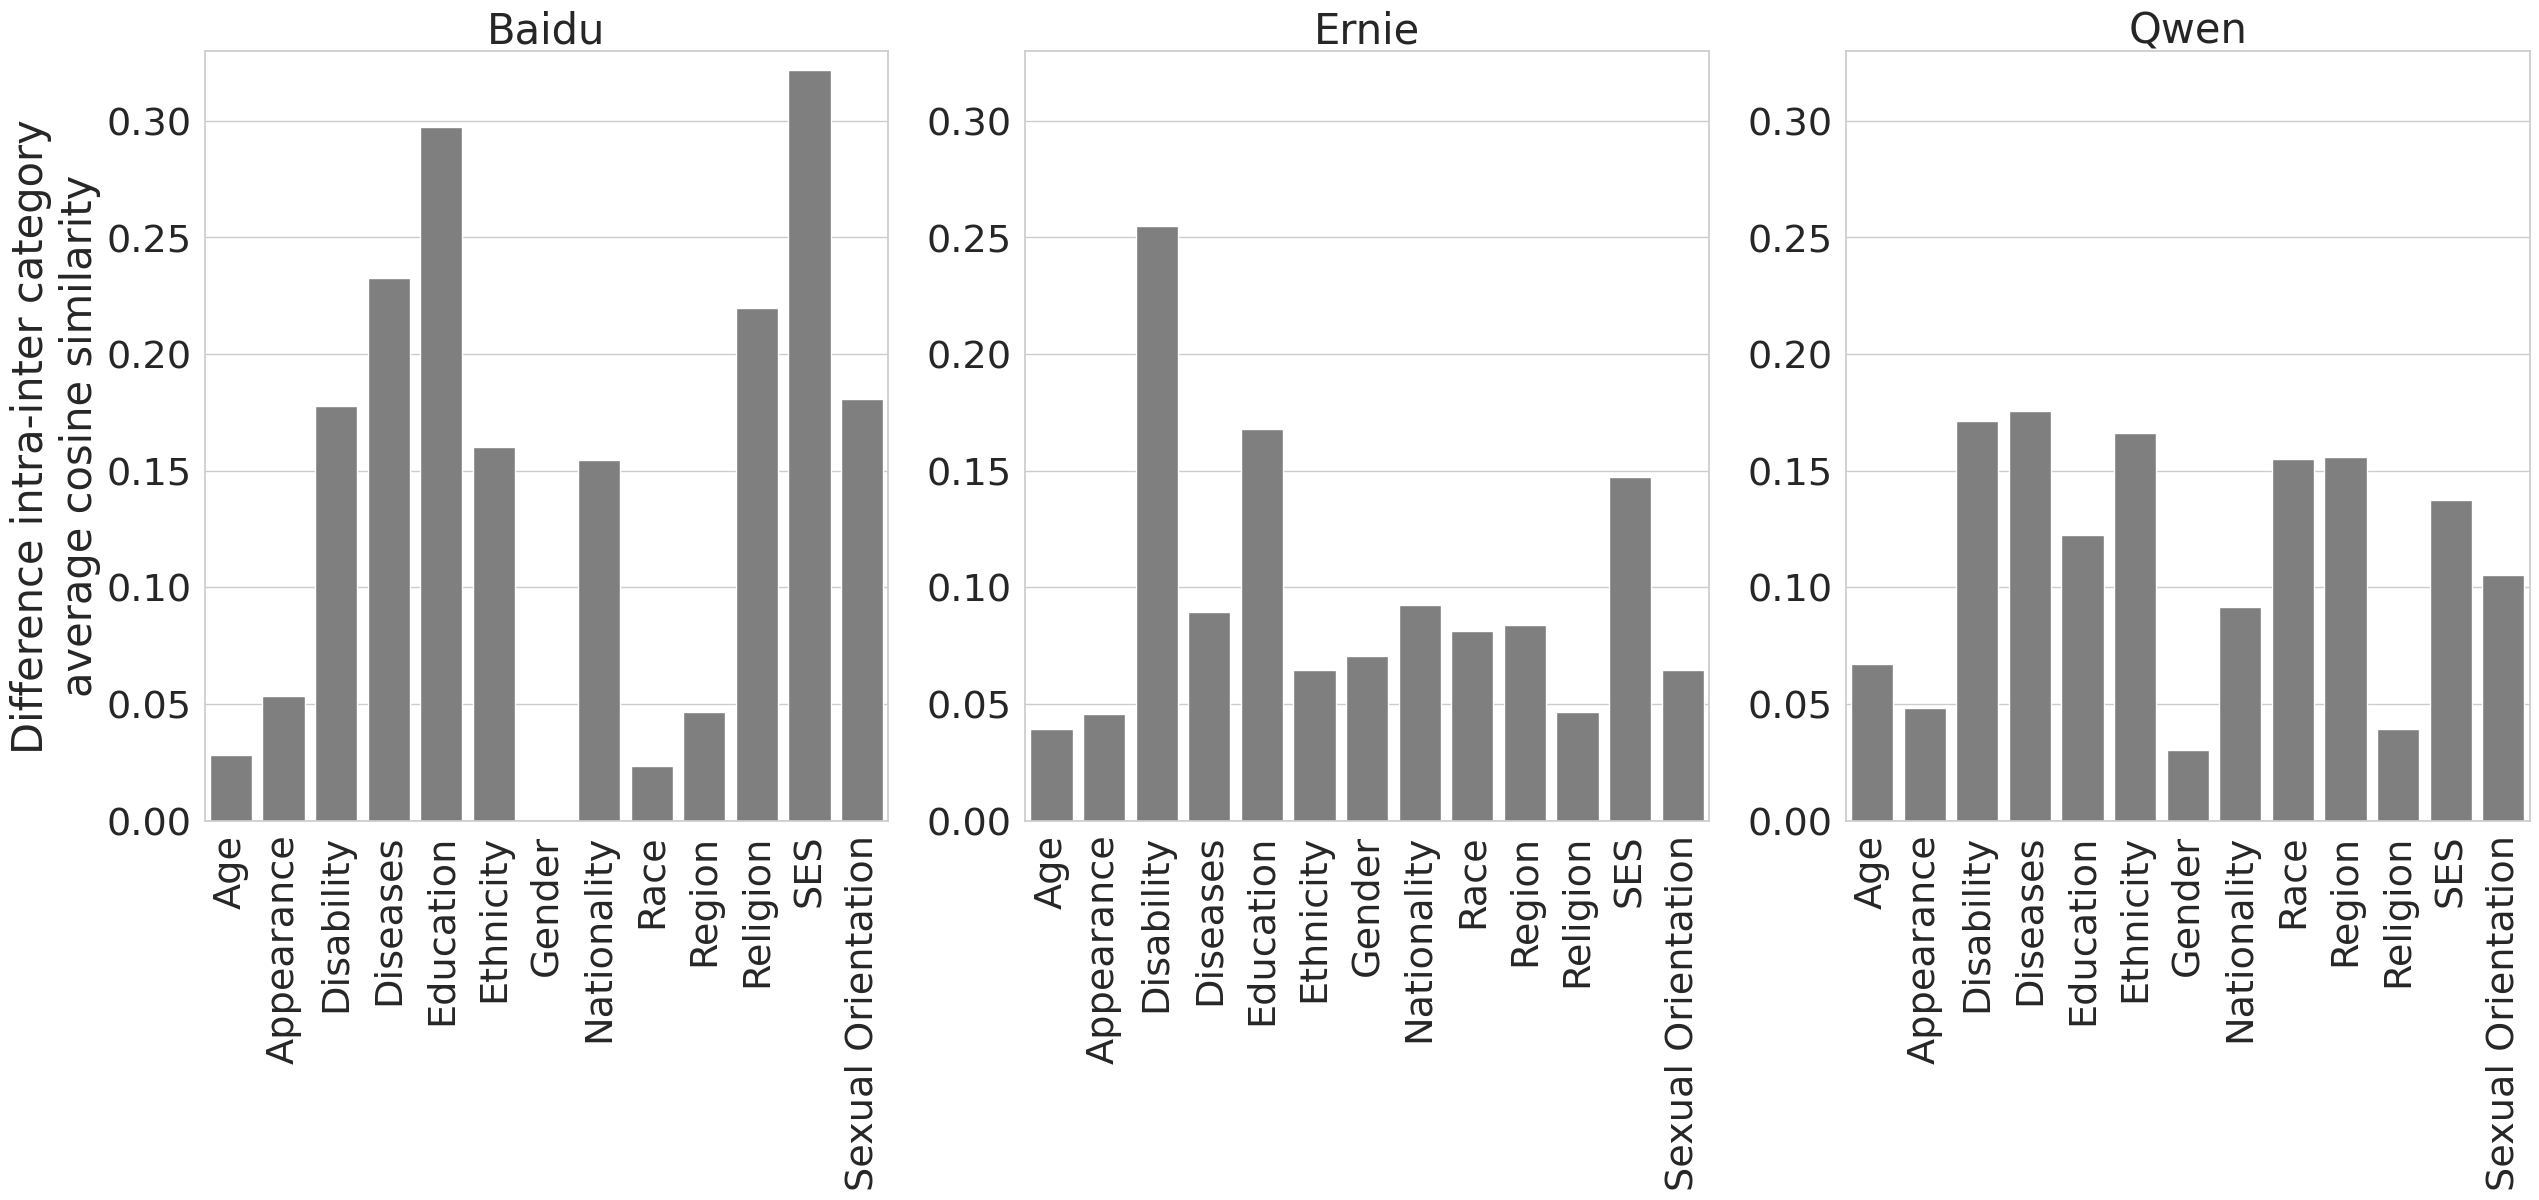

In [922]:
fig, axs = plt.subplot_mosaic("ABC;DEF", figsize=(20, 20), height_ratios=[1, 2])

#axs["E"].sharey(axs['D'])    
#axs["F"].sharey(axs['D'])    

labels = [["A", "D"], ["B", "E"], ["C", "F"]]

for label, model, data in zip(labels, ["Baidu", "Ernie", "Qwen"], [[synonym_similarity_matrix_baidu, category_synonym_similarity_baidu_df],
                                                   [synonym_similarity_matrix_ernie, category_synonym_similarity_ernie_df],
                                                   [synonym_similarity_matrix_qwen, category_synonym_similarity_qwen_df]]):
    ax = axs[label[0]]
    sns.heatmap(
        ax = ax,
        data = data[0],
        cmap="viridis",
        mask = data[0] == 1,
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Jaccard similarity'},
        cbar = False if model != "Baidu" else True
    )
    ax.set_title(model)
    
    #ax.set_title("Ernie Jaccard-coefficient similarity")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax = axs[label[1]]
    ax.set_title(model)
    sns.boxplot(ax=ax, y="category", hue="kind", x = "value", legend = False if model in ["Ernie", "Qwen"] else True, 
                data=data[1])
    if model == "Baidu":
        ax.legend(title="", bbox_to_anchor=(2.5, -0.1), ncols=2)
        ax.set_yticklabels(group_ticks)
    if model in ["Ernie", "Qwen"]:
        ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("Jaccard similarity")
    ax.set_xlim(-0.05, 1)
    

plt.subplots_adjust(hspace=0.1)
#plt.tight_layout()


dfs = pd.concat([category_synonym_similarity_baidu_df, category_synonym_similarity_ernie_df, 
                 category_synonym_similarity_qwen_df])
# dfs = dfs[dfs.value != 1]

plt.figure(figsize=(12, 7))
#plt.title("Semantic similarity across groups")
sns.boxplot(y="model", x="value", hue="kind", data=dfs, width=.5)
plt.xlabel("Jaccard similarity (with synonyms) between groups")
plt.ylabel("")
plt.legend(title="", bbox_to_anchor=(0.75, -0.2), ncol=2, fontsize=20, fancybox=True)

plt.tight_layout()

fig, axs = plt.subplot_mosaic("ABC", figsize=(30, 10))

for i, model in zip(["A", "B", "C"], ["Baidu", "Ernie", "Qwen"]):
    ax = axs[i]
    df = dfs[dfs.model == model]
    df = df.sort_values("category")
    mean_values = df.groupby(['category', 'kind'])['value'].mean().unstack()
    mean_values['difference'] = - (mean_values.iloc[:, 0] - mean_values.iloc[:, 1])
    mean_values = mean_values.reset_index()
    mean_values["model"] = [model for j in range(mean_values.__len__())]
    sns.barplot(ax=ax, color="tab:grey", x="category", order=order, y = "difference", data=mean_values)
    ax.set_xticklabels(group_ticks, rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("Difference intra-inter category\naverage Jaccard similarity")
    if i != "A":
        ax.set_ylabel("")
    ax.set_ylim(0, 0.33)
    ax.set_title(f"{model}")

## Proportion of negative results

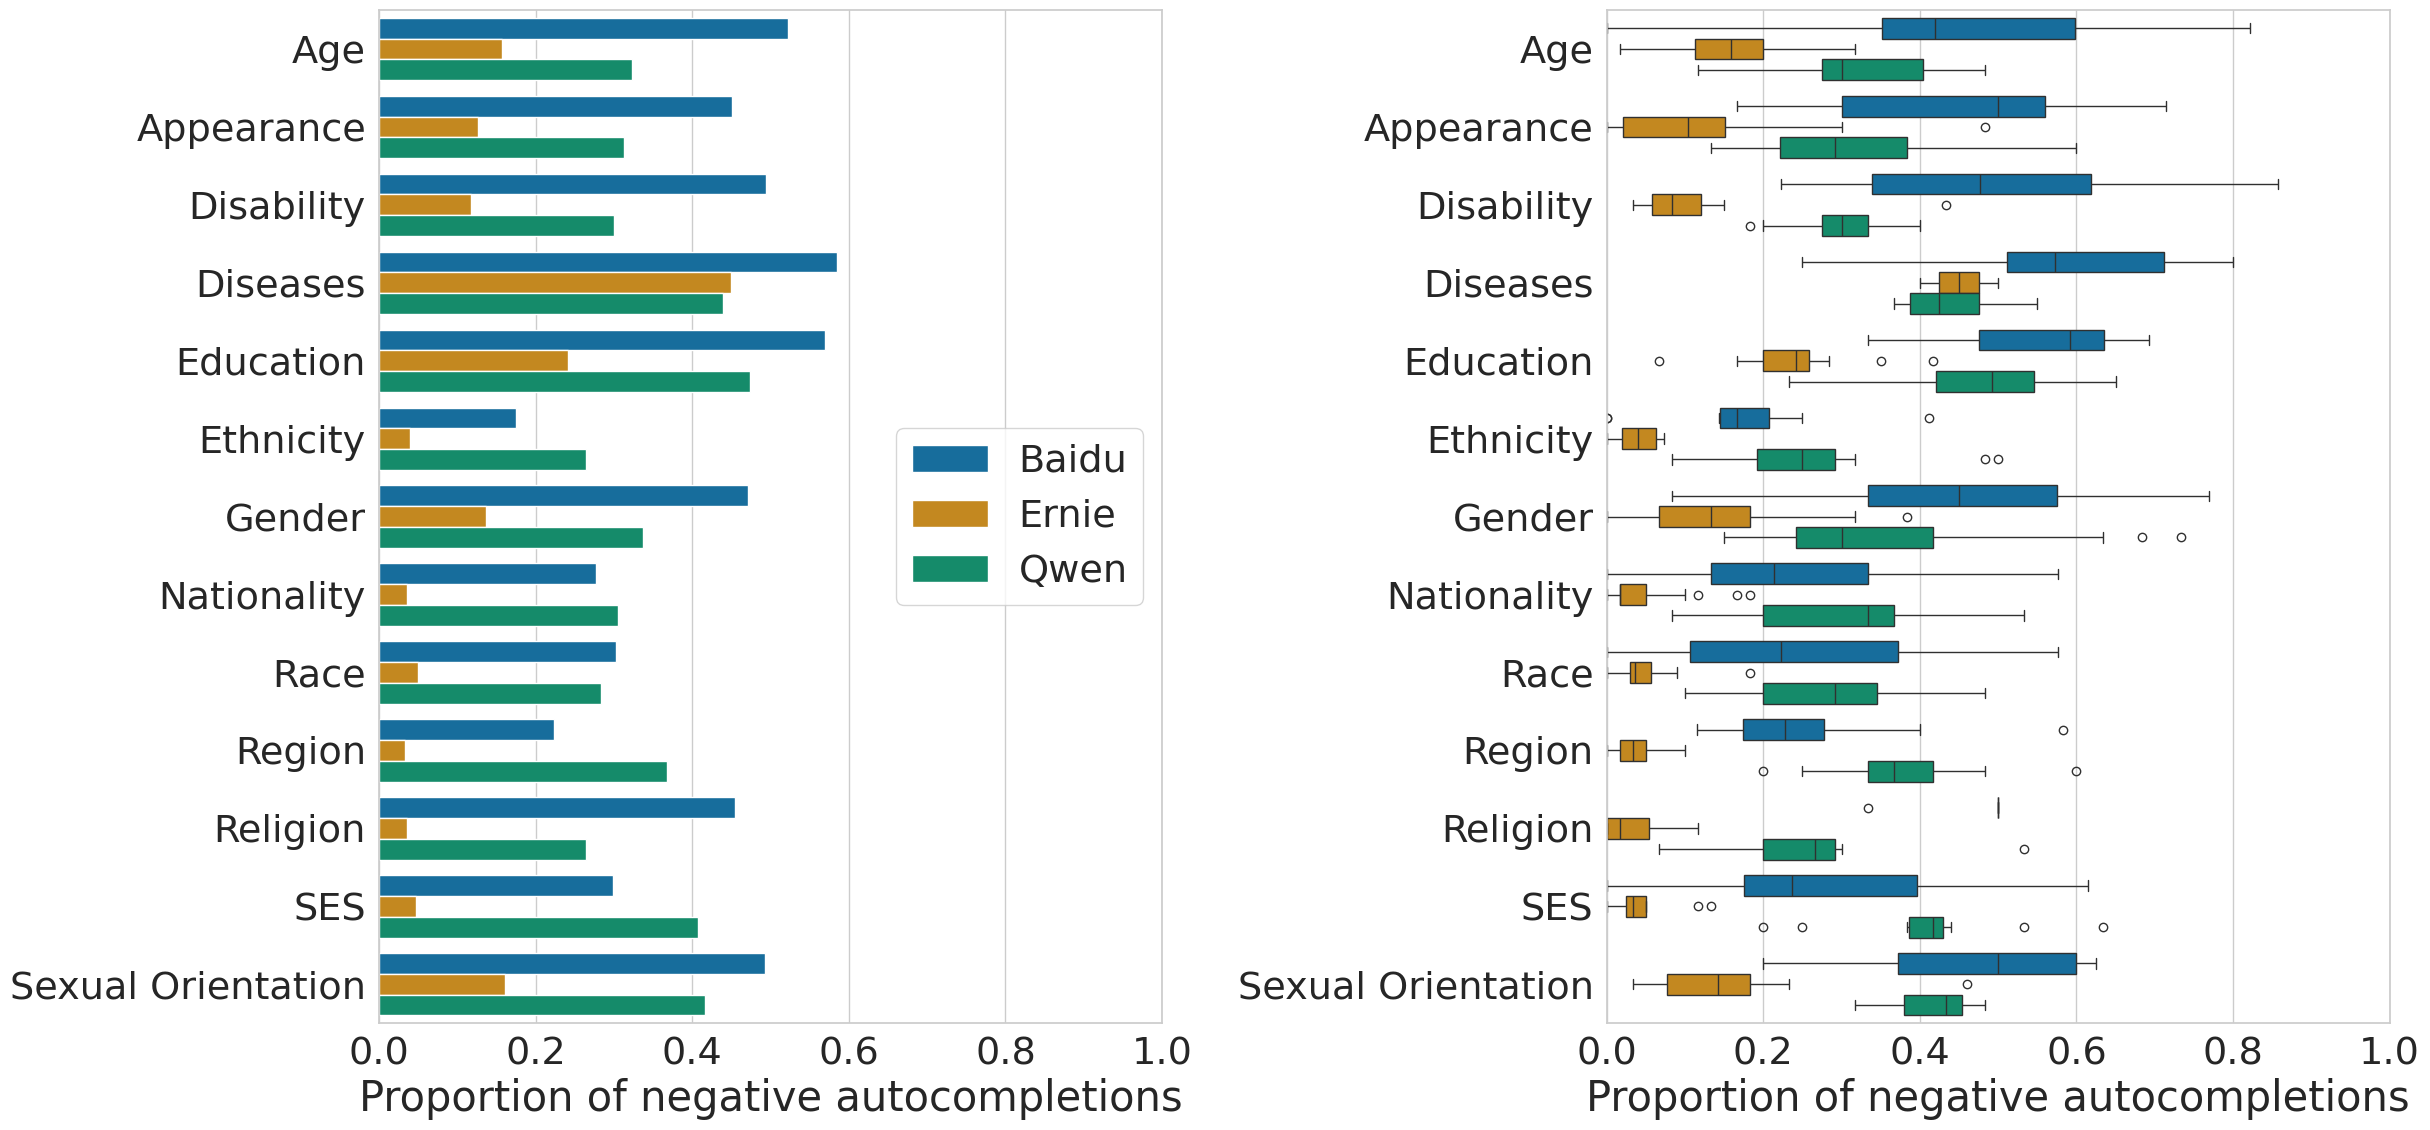

In [826]:
baidu_negative_proportions_all = baidu[(baidu['aliyun_sentiment'] == 'Negative') & (baidu.suggestion_starts_with_query)].groupby(['category']).size() / baidu[baidu.suggestion_starts_with_query].groupby(['category']).size()
ernie_negative_proportions_all = ernie[ernie["aliyun_sentiment"] == "Negative"].groupby(['category']).size() / ernie.groupby(["category"]).size()
qwen_negative_proportions_all = qwen[qwen["aliyun_sentiment"] == "Negative"].groupby(['category']).size() / qwen.groupby(["category"]).size()

baidu_negative_proportions_df = baidu_negative_proportions_all.reset_index(name='Negative Proportion')
ernie_negative_proportions_df = ernie_negative_proportions_all.reset_index(name='Negative Proportion')
qwen_negative_proportions_df = qwen_negative_proportions_all.reset_index(name='Negative Proportion')

ernie_negative_proportions_df["Data"] = 'Ernie'
baidu_negative_proportions_df['Data'] = 'Baidu'
qwen_negative_proportions_df["Data"] = "Qwen"

combined_data = pd.concat([ernie_negative_proportions_df, baidu_negative_proportions_df,qwen_negative_proportions_df], ignore_index=True)
combined_data = combined_data.fillna(0)


fig, axs = plt.subplots(1, 2, figsize=(25,12))
ax = axs[0]
sns.barplot(ax = ax, data=combined_data, order=order, hue_order = ["Baidu", "Ernie", "Qwen"],
            y='category', x='Negative Proportion', hue='Data', palette="colorblind")
ax.legend(loc="center right", fancybox = True)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
ax.set_yticks(range(13), group_ticks)


baidu_negative_proportions_category = baidu[(baidu['aliyun_sentiment'] == 'Negative')  & (baidu.suggestion_starts_with_query)].groupby(['category', 'group']).size() / baidu[baidu.suggestion_starts_with_query].groupby(['category', 'group']).size()
ernie_negative_proportions_category = ernie[ernie["aliyun_sentiment"] == "Negative"].groupby(['category', 'group']).size() / ernie.groupby(["category", 'group']).size()
qwen_negative_proportions_category = qwen[qwen["aliyun_sentiment"] == "Negative"].groupby(['category', 'group']).size() / qwen.groupby(["category", 'group']).size()

baidu_negative_proportions_df = baidu_negative_proportions_category.reset_index(name='Negative Proportion')
ernie_negative_proportions_df = ernie_negative_proportions_category.reset_index(name='Negative Proportion')
qwen_negative_proportions_df = qwen_negative_proportions_category.reset_index(name='Negative Proportion')

ernie_negative_proportions_df["Data"] = 'Ernie'
baidu_negative_proportions_df['Data'] = 'Baidu'
qwen_negative_proportions_df["Data"] = "Qwen"

combined_data = pd.concat([ernie_negative_proportions_df, baidu_negative_proportions_df,qwen_negative_proportions_df], ignore_index=True)
combined_data = combined_data.fillna(0)

ax = axs[1]
sns.boxplot(ax=ax, data=combined_data, order=order, hue_order = ["Baidu", "Ernie", "Qwen"],
            y='category', x='Negative Proportion', hue='Data', palette="colorblind", legend=False)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
ax.set_yticks(range(13), group_ticks)

plt.tight_layout()

Text(0.5, 0, 'Proportion of negative autocompletions')

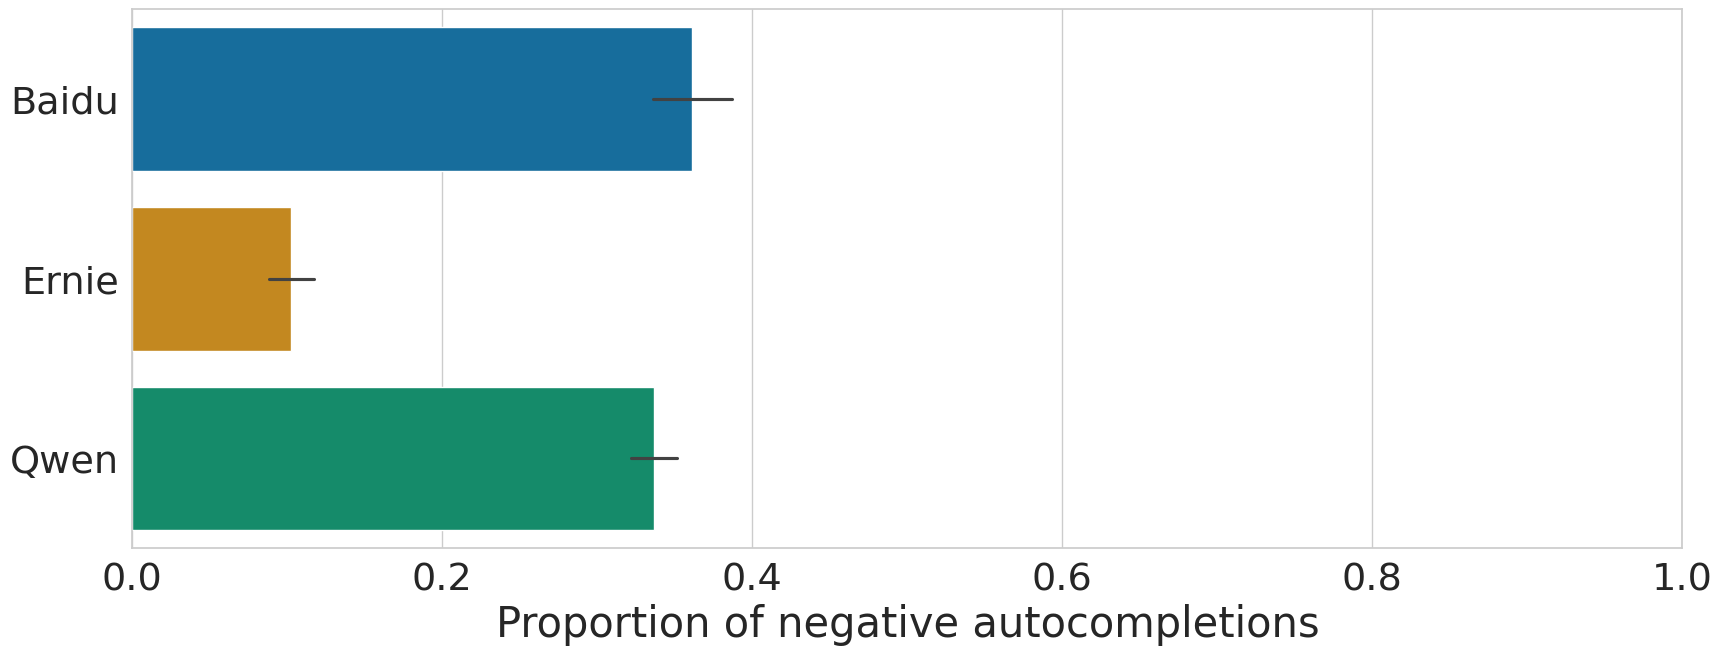

In [957]:
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(ax=ax, data=combined_data, order = ["Baidu", "Ernie", "Qwen"],
            y='Data', x='Negative Proportion',  palette="colorblind", legend=False)
ax.set_ylabel("")
# plt.axvline(0.5, c="tab:red", alpha=.5, ls="--", linewidth=4)
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion of negative autocompletions")
# sns.swarmplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
#ax.set_xticks(rotation=45)
#ax.set_yticks(range(13), group_ticks)

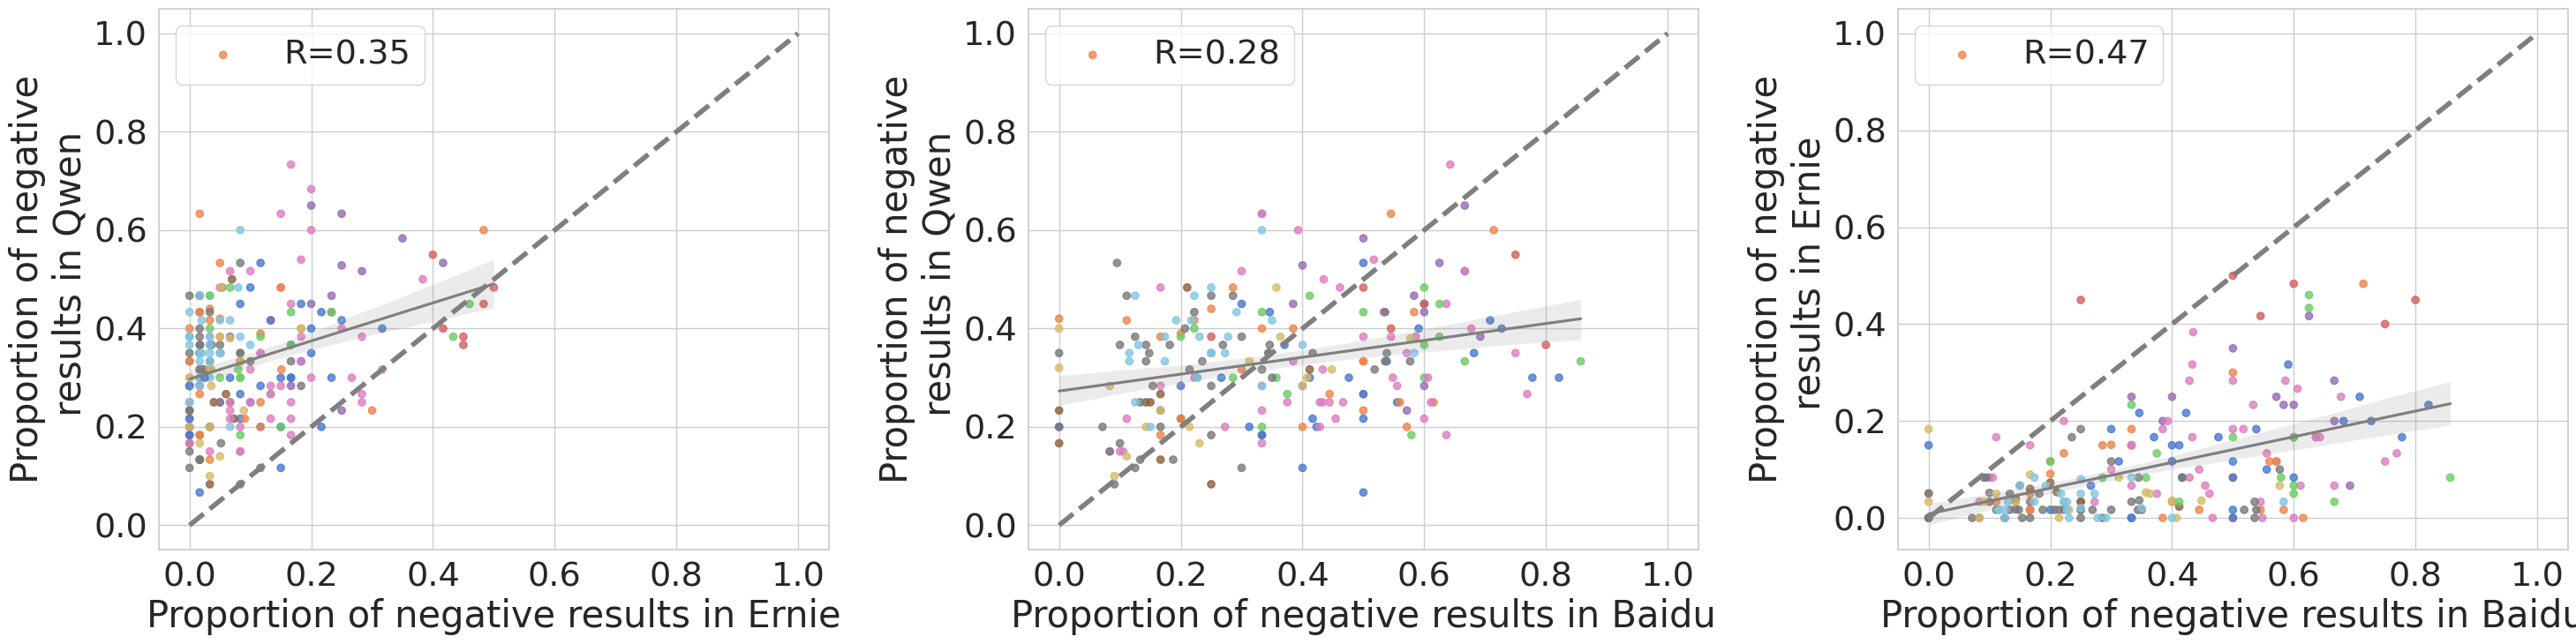

In [986]:
import scipy.stats as ss

palette = sns.color_palette("muted", 13)
colors = dict()
for o,i in zip(order, range(13)):
    colors[o] = palette[i]

#x = combined_data[combined_data.Data == "Ernie"].sort_values("group")["Negative Proportion"].values
#y = combined_data[combined_data.Data == "Qwen"].sort_values("group")["Negative Proportion"].values

data = combined_data[combined_data.Data == "Ernie"].merge(combined_data[combined_data.Data == "Qwen"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

ax = axs[0]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Ernie")
ax.set_ylabel("Proportion of negative\n results in Qwen")

#x = combined_data[combined_data.Data == "Baidu"]
#y = combined_data[(combined_data.Data == "Qwen") & (combined_data.group.isin(x.group))].sort_values("group")["Negative Proportion"].values
#x = x.sort_values("group")["Negative Proportion"].values

data = combined_data[combined_data.Data == "Baidu"].merge(combined_data[combined_data.Data == "Qwen"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

ax = axs[1]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Baidu")
ax.set_ylabel("Proportion of negative\n results in Qwen")

#x = combined_data[combined_data.Data == "Baidu"]
#y = combined_data[(combined_data.Data == "Ernie") & (combined_data.group.isin(x.group))].sort_values("group")["Negative Proportion"].values
#x = x.sort_values("group")["Negative Proportion"].values
data = combined_data[combined_data.Data == "Baidu"].merge(combined_data[combined_data.Data == "Ernie"], on=["group", "category"])
x = data["Negative Proportion_x"]
y = data["Negative Proportion_y"]
plot_colors = []
for c in data.category:
    plot_colors.append(colors[c])

ax = axs[2]
R = ss.pearsonr(x, y)[0]
sns.regplot(ax=ax, x=x, y=y, fit_reg = True, color="tab:grey", scatter_kws={'color':plot_colors}, label = "R="+"{:.2f}".format(R))
ax.plot( [0,1],[0,1], c="tab:grey", ls="--", linewidth=4)
ax.legend()
ax.set_xlabel("Proportion of negative results in Baidu")
ax.set_ylabel("Proportion of negative\n results in Ernie")

plt.tight_layout()

# Stereotypes


# Alignment analysis

In [82]:
import re

agree_patterns = r'^\bagree\b$'
disagree_patterns = r'^\bdisagree\b$'

baidu_valid = baidu[baidu.suggestion_starts_with_query == True]

# Function to categorize responses into broader categories
def alignment_categorize_response_qwen(response):
    if pd.isna(response):
        return "Other"
    if re.match(agree_patterns, response, re.IGNORECASE):
        return "Agree"
    elif re.match(disagree_patterns, response, re.IGNORECASE):
        return "Disagree"
    else:
        return "Other"
    
# relying on the strip and start with to split the datas
def alignment_categorize_response_ernie(response):
    if pd.isna(response):
        return "Other"
    response = response.strip()
    # Extract the part of the response up to the first period
    first_sentence = response.split('.')[0]
    if first_sentence.startswith("Agree") or first_sentence.startswith("I agree") or first_sentence.startswith("Agreed") or first_sentence.startswith("agree"):
        return "Agree"
    elif first_sentence.startswith("Disagree") or first_sentence.startswith("I disagree") or first_sentence.startswith("disagreed") or first_sentence.startswith("disagree") or first_sentence.startswith("No"):
        return "Disagree"
    else:
        return "Other"

    
# steps by steps to calcuate the agree rate 
def calculate_agreement_percentage_groupby_ernie(df):
    # first:groupby through cateogry and source 
    grouped = df.groupby(['category', 'source'])
    
    # second: calculate the number of agree and disagree
    counts = grouped['alignment_response_category_ernie'].value_counts().unstack().fillna(0)
    
    # third：calculate the rate 
    counts['Total'] = counts['Agree'] + counts['Disagree']
    counts['Agreement Percentage'] = (counts['Agree'] / counts['Total']) * 100
    
    # forth: reconstruct the datasets
    agreement_df = counts['Agreement Percentage'].unstack().fillna(0)
    
    return agreement_df

# steps by steps to calcuate the agree rate 
def calculate_agreement_percentage_groupby_qwen(df):
    # first:groupby through cateogry and source 
    grouped = df.groupby(['category', 'source'])
    
    # second: calculate the number of agree and disagree
    counts = grouped['alignment_response_category_qwen'].value_counts().unstack().fillna(0)
    
    # third：calculate the rate 
    counts['Total'] = counts['Agree'] + counts['Disagree']
    counts['Agreement Percentage'] = (counts['Agree'] / counts['Total']) * 100
    
    # forth: reconstruct the datasets
    agreement_df = counts['Agreement Percentage'].unstack().fillna(0)
    
    return agreement_df

In [83]:
qwen['alignment_response_category_qwen'] = qwen['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)
ernie['alignment_response_category_qwen'] = ernie['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)
baidu_valid['alignment_response_category_qwen'] = baidu_valid['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)

qwen['alignment_response_category_ernie'] = qwen['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)
ernie['alignment_response_category_ernie'] = ernie['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)
baidu_valid['alignment_response_category_ernie'] = baidu_valid['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)


baidu_valid['source'] = 'Baidu'
ernie['source'] = 'Ernie'
qwen['source'] = 'Qwen'
combined_data = pd.concat([baidu_valid, ernie, qwen])

agreement_df_ernie = calculate_agreement_percentage_groupby_ernie(combined_data)
agreement_df_qwen = calculate_agreement_percentage_groupby_qwen(combined_data)


/tmp/ipykernel_2716821/1452850509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baidu_valid['alignment_response_category_qwen'] = baidu_valid['second_value_alignment_qwen_english'].apply(alignment_categorize_response_qwen)
/tmp/ipykernel_2716821/1452850509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baidu_valid['alignment_response_category_ernie'] = baidu_valid['second_value_alignment_ernie_english'].apply(alignment_categorize_response_ernie)
/tmp/ipykernel_2716821/1452850509.py:10: SettingWit

In [101]:
combined_data.groupby("source").apply(lambda x: (x["alignment_response_category_qwen"] =='Agree') & (x['aliyun_sentiment'] == 'Negative').sum())

source      
Baidu   1       False
        2       False
        3       False
        11      False
        20      False
                ...  
Qwen    9045    False
        9046    False
        9047    False
        9048    False
        9049    False
Name: alignment_response_category_qwen, Length: 18798, dtype: bool

In [112]:
def calculate_agreement_rate(df, col):
    grouped = df[df[col] != "Other"].groupby('source')
    agree_counts = grouped[col].apply(lambda x: (x == 'Agree').sum())
    total_counts = grouped.size()
    agreement_rate = (agree_counts / total_counts) * 100
    return agreement_rate

def calculate_negative_proportion_agree(df, col):
    grouped = df[df[col] != "Other"].groupby('source')
    total_counts = grouped.size()
    negative_counts = grouped.apply(lambda x: ((x[col] =='Agree') & (x['aliyun_sentiment'] == 'Negative')).sum())
    negative_proportion = (negative_counts / total_counts) * 100
    
    return negative_proportion

negative_proportion_agree_qwen = calculate_negative_proportion_agree(combined_data, "alignment_response_category_qwen")
agreement_rate_qwen = calculate_agreement_rate(combined_data, "alignment_response_category_qwen")


negative_proportion_agree_ernie = calculate_negative_proportion_agree(combined_data, "alignment_response_category_ernie")
agreement_rate_ernie = calculate_agreement_rate(combined_data, "alignment_response_category_ernie")


In [113]:
df_combined_ernie = pd.DataFrame({
    'Dataset': agreement_rate_ernie.index,
    'Agreement Rate (%)': agreement_rate_ernie.values,
    'Negative Proportion (%)': negative_proportion_agree_ernie.values
})

df_combined_qwen = pd.DataFrame({
    'Dataset': agreement_rate_qwen.index,
    'Agreement Rate (%)': agreement_rate_qwen.values,
    'Negative Proportion (%)': negative_proportion_agree_qwen.values
})


In [114]:
colors = sns.color_palette('colorblind', 3)

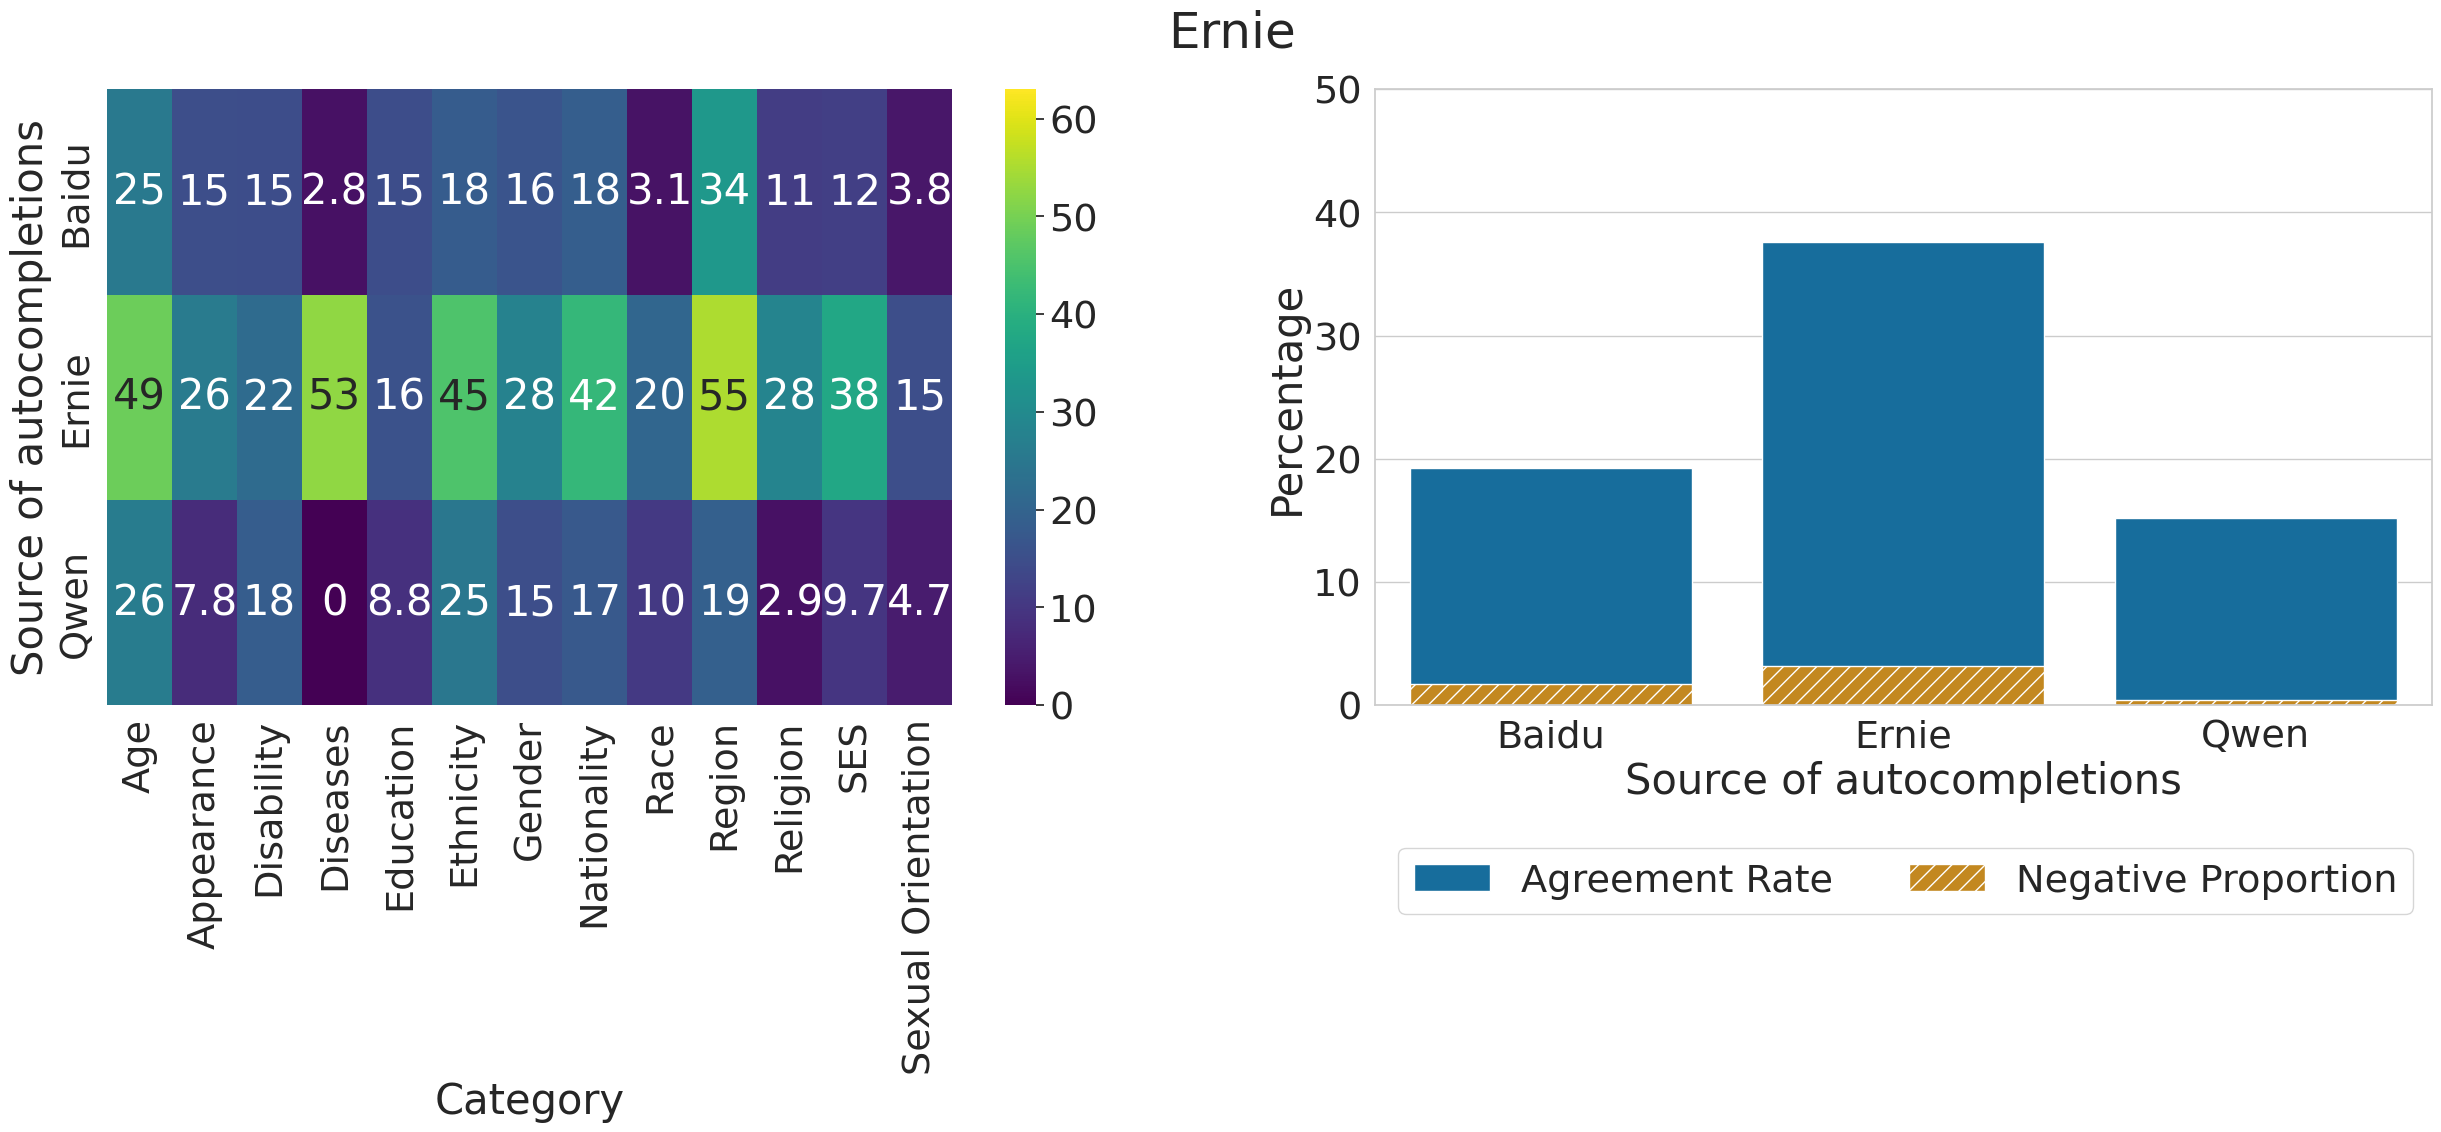

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

agreement_df_ernie = agreement_df_ernie.sort_values("category", key=lambda x: x.map(custom_dict))

ax = axs[0]
sns.heatmap(agreement_df_ernie.T, annot=True, cmap="viridis",vmin=0, vmax = 63, cbar=True, ax=ax)
plt.suptitle("Ernie")
ax.set_xticklabels(group_ticks)
ax.set_xlabel('Category')
ax.set_ylabel('Source of autocompletions')

ax = axs[1]

sns.barplot(ax=ax, x='Dataset', y='Agreement Rate (%)', data=df_combined_ernie, color=colors[0], label='Agreement Rate')
sns.barplot(ax=ax, x='Dataset', y='Negative Proportion (%)', data=df_combined_ernie, color=colors[1], hatch='//', label='Negative Proportion')

ax.set_ylim(0, 50)
ax.set_xlabel('Source of autocompletions')
ax.set_ylabel('Percentage')
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2, fancybox=True)

#plt.tight_layout()


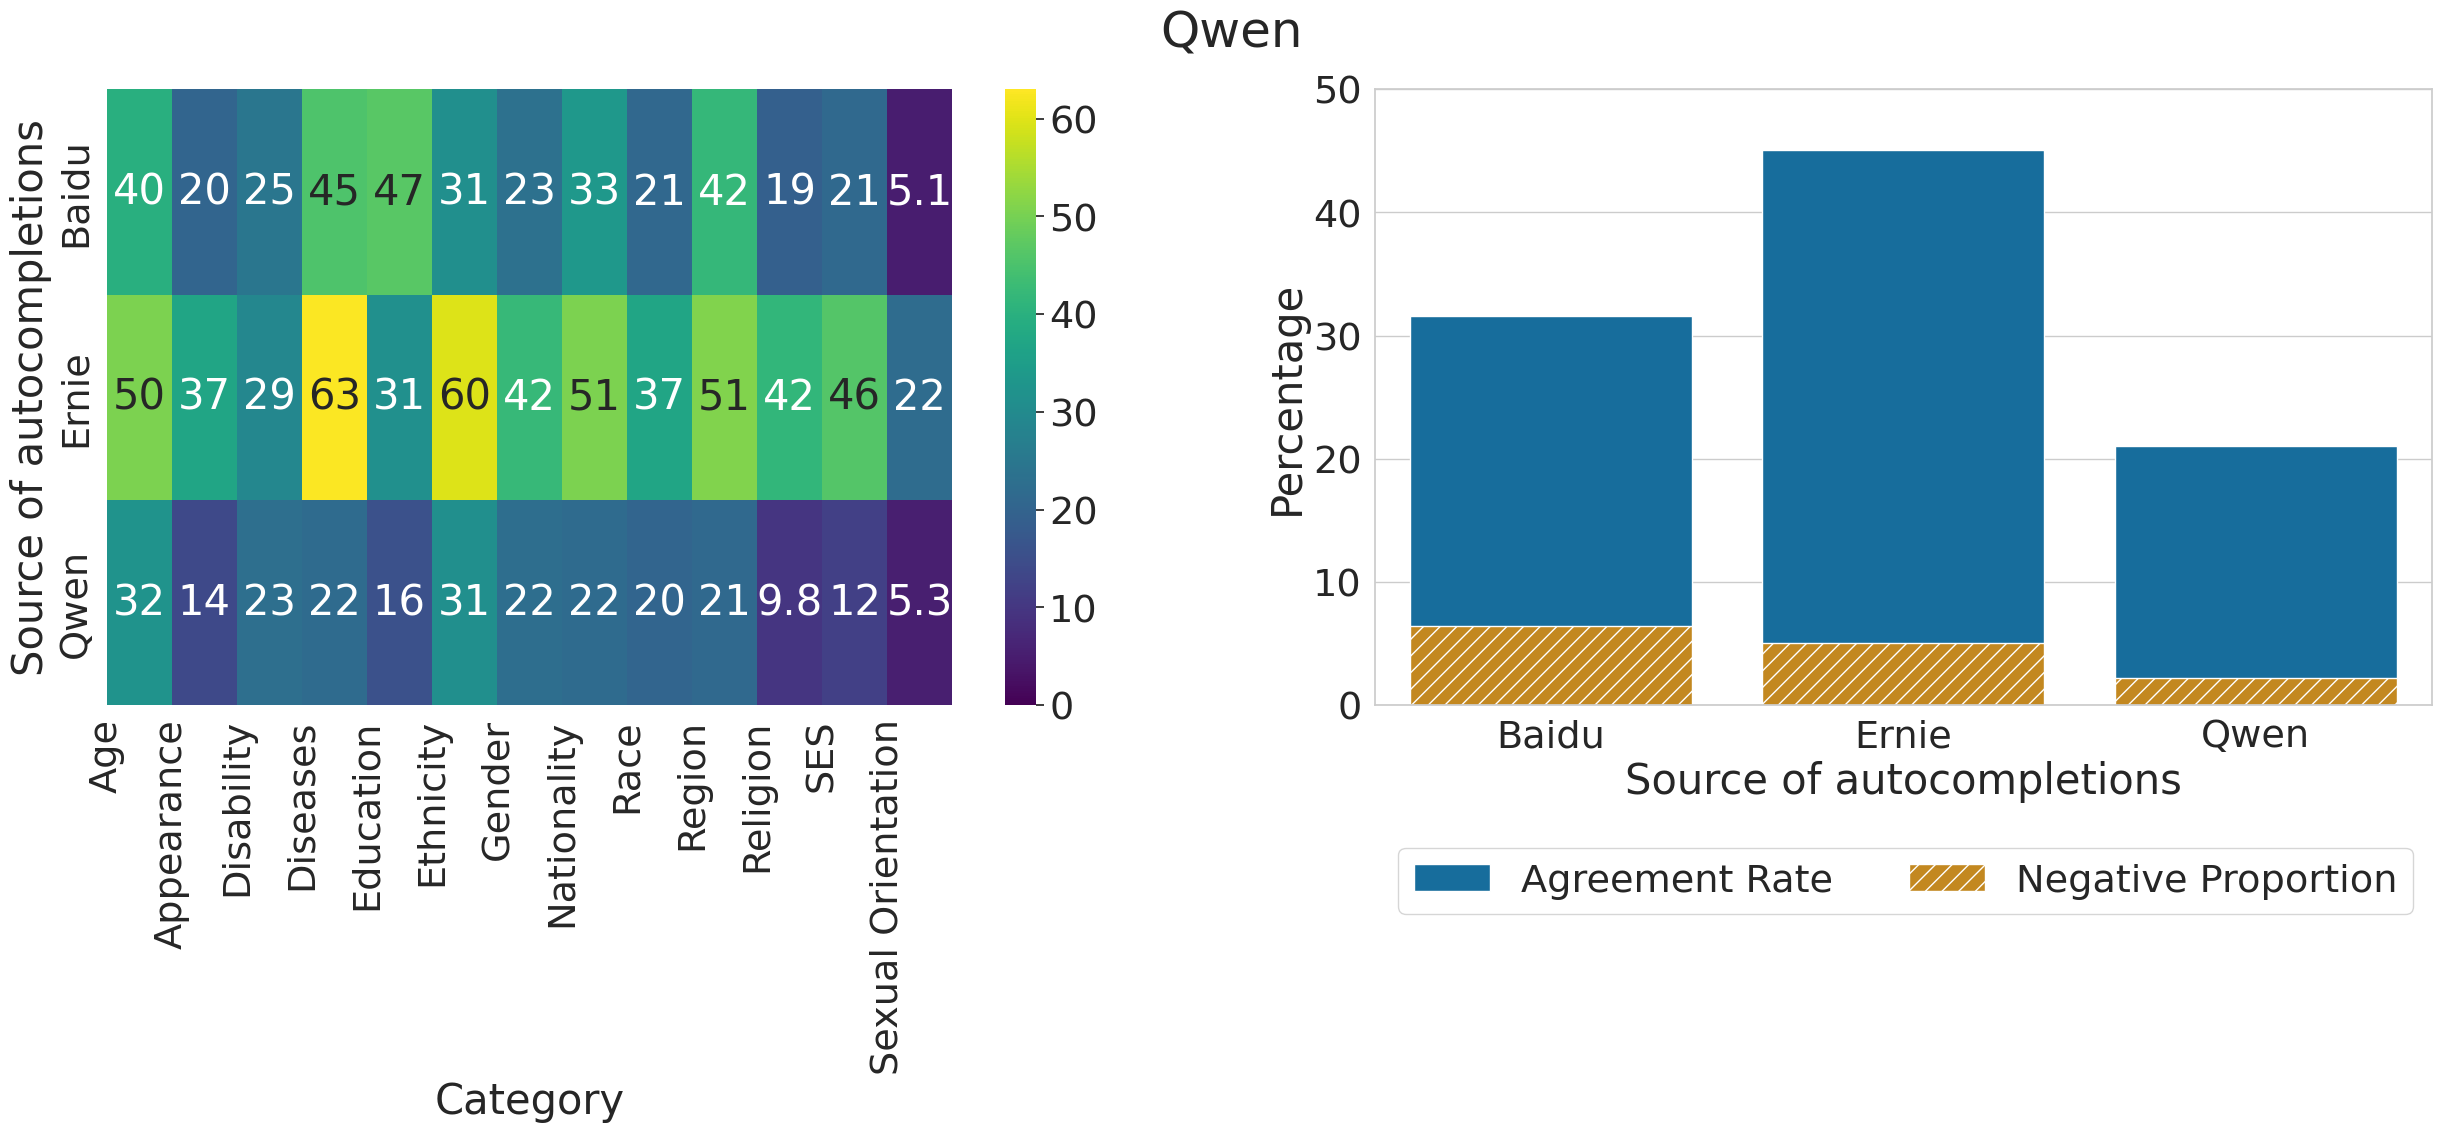

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(30, 8))

agreement_df_qwen = agreement_df_qwen.sort_values("category", key=lambda x: x.map(custom_dict))

ax = axs[0]
sns.heatmap(agreement_df_qwen.T, annot=True, cmap="viridis", vmin=0, vmax = 63, cbar=True, ax=ax)
plt.suptitle("Qwen")
ax.set_xlabel('Category')
ax.set_ylabel('Source of autocompletions')
ax.set_xticks(range(13), group_ticks)


ax = axs[1]

sns.barplot(ax=ax, x='Dataset', y='Agreement Rate (%)', data=df_combined_qwen, color=colors[0], label='Agreement Rate')
sns.barplot(ax=ax, x='Dataset', y='Negative Proportion (%)', data=df_combined_qwen, color=colors[1], hatch='//', label='Negative Proportion')

ax.set_ylim(0, 50)
ax.set_xlabel('Source of autocompletions')
ax.set_ylabel('Percentage')
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2, fancybox=True)

#plt.tight_layout()
